In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from utils import *
import pickle

# Finding Skin Tone Clusters
#### Follows Section 3.4 of paper
##### Find statistical bounds for Cr and Cb based on the luminance range

In [ ]:
#gets two lists (one for cr, one for cb) of pixel values, divided by y channel
def getHistograms():
    with open('landmark_list_part1.txt') as f:
        lines = f.readlines()
        lines = [line.split(" ")  for line in lines]

    Crs = {}
    Cbs = {}

    bounds = [0, 40, 40, 60, 190, 210, 255]

    #look through 2000 images and extract statistical data about the channels
    for i in range(2000):
        data = lines[i]
        filename = "part1//" + data[0]
        img = get_ycc_image(filename)

        for j in range(len(bounds)-1):
            #get Cr and Cb for given Y range
            lower = bounds[j]
            upper = bounds[j+1]
            mask1 = img[:,:,0] > lower
            mask2 = img[:,:,0] < upper
            cr = mask1*mask2*img[:,:,1]
            cb = mask1*mask2*img[:,:,2]

            name = str(lower)+"_"+str(upper)

            if name in Crs:
                temp = Crs[name]
                temp.append(cr)
                Crs[name] = temp
            else:
                Crs[name] = [cr]

            if name in Cbs:
                temp = Cbs[name]
                temp.append(cb)
                Cbs[name] = temp
            else:
                Cbs[name] = [cb]
                
    #flatten data into list of cr values or cb values (respectively) at each Y range
    cr_flats = {}
    cb_flats = {}

    for lum_range in Crs:
        print(lum_range)
        cr_images = Crs[lum_range]
        cr_flat = [ np.array(img).flatten() for img in cr_images]
        cr_flat = np.concatenate(cr_flat)
        cr_flat = cr_flat[cr_flat != 0]
        cr_flats[lum_range] = cr_flat

        cb_images = Cbs[lum_range]
        cb_flat = [ np.array(img).flatten() for img in cb_images]
        cb_flat = np.concatenate(cb_flat)
        cb_flat = cb_flat[cb_flat != 0]
        cb_flats[lum_range] = cb_flat
        
    return cr_flats, cb_flats

def draw_histograms(cr_flats, cb_flats):
    #plot frequency based on Y range
    for lum_range in cr_flats:
        plt.hist(cr_flats[lum_range], bins=256)
        plt.title("CR_"+lum_range)
        plt.show()
        plt.hist(cb_flats[lum_range], bins=256)
        plt.title("CB_"+lum_range)
        plt.show()


In [ ]:
#cr_data, cb_data = getHistograms()
#draw_histograms(cr_data, cb_data) 

# Skin-Pixel Classification
#### Follows Section 3.4 of paper
##### For each pixel, classify as skin or not skin using ranges calculated above

In [ ]:
def get_skin_mask(img):
    #ranges are inclusive
    min_range1 = np.array([0,153,77])
    max_range1 = np.array([40,173,95])

    min_range2 = np.array([41,153,77])
    max_range2 = np.array([60,173,105])

    min_range3 = np.array([61,133,77])
    max_range3 = np.array([190,173,127])

    min_range4 = np.array([191,140,100])
    max_range4 = np.array([210,160,175])

    min_range5 = np.array([211,143,0])
    max_range5 = np.array([255,163,130])

    min_ranges = [min_range1, min_range2, min_range3, min_range4, min_range5]
    max_ranges = [max_range1, max_range2, max_range3, max_range4, max_range5]

    #logical or the masks of each range and apply to image
    skin_mask = np.ones((len(img), len(img[0])))
    for mins,maxs in zip (min_ranges, max_ranges):
        new_mask = cv2.inRange(img, mins, maxs)
        skin_mask = skin_mask + new_mask
        
    return skin_mask



# Remove False Skin / Extract ROI
#### Mentioned in Section 3.5
##### Determine which skin is face and extract

In [ ]:
""" 
Source: https://stackoverflow.com/questions/64345584/how-to-properly-use-cv2-findcontours-on-opencv-version-4-4-0
cv2.RETR_LIST → Retrieve all contours
cv2.RETR_EXTERNAL → Retrieves external or outer contours only
cv2.RETR_COMP → Retrieves all in a 2-level hierarchy
cv2.RETR_TREE → Retrieves all in the full hierarchy

cv2.CHAIN_APPROX_NONE stores all the boundary points
cv2.CHAIN_APPROX_SIMPLE removes some
"""

'    \ncv2.RETR_LIST → Retrieve all contours\ncv2.RETR_EXTERNAL → Retrieves external or outer contours only\ncv2.RETR_COMP → Retrieves all in a 2-level hierarchy\ncv2.RETR_TREE → Retrieves all in the full hierarchy\n\ncv2.CHAIN_APPROX_NONE stores all the boundary points\ncv2.CHAIN_APPROX_SIMPLE removes some\n'

In [ ]:
def get_face_box(skin_mask, img):
    #Use contour data to create bounding box around the skin pixels that represent the face
    _, skin_mask = cv2.threshold(skin_mask, 255//2, 255, cv2.THRESH_BINARY)
    skin_mask = np.uint8(skin_mask)
    cont_img = img.copy()

    contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        print("Error: no contours. Using whole image as face")
        return [0,0,img.shape[1], img.shape[0]], contours
    else:
        c = max(contours, key = cv2.contourArea)
        rect = cv2.boundingRect(c)
        return rect, contours
    
def draw_face_box(rect, contours, img):
    cont_img = img.copy()
    if len(contours) > 0:
        cont_img = cv2.drawContours(cont_img, contours, -1, 255, 3)
    x,y,w,h = rect
    cv2.rectangle(cont_img,(x,y),(x+w,y+h),(255,0,0),2)
    show_image(cont_img, "ycc")

# Find Eyes
#### Follows Section 3.1 of paper
##### Find dark groups of pixels in formation of eyes

In [ ]:
#Find dark regions around eyes by finding all dark blobs at a certain
#threshold, as described in Equations 1-5 in the paper
def get_blobs(img):
    #Source: https://learnopencv.com/blob-detection-using-opencv-python-c/
    #img must be uint8 to work with cv2
    
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 50;
    params.maxThreshold = 100;

    # Filter by Area.
    params.filterByArea = False
    params.minArea = 1500

    # Filter by Circularity
    params.filterByCircularity = False
    
    params.minCircularity = 0.5

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs.
    keypoints = detector.detect(img)
    pts = cv2.KeyPoint_convert(keypoints)
    return keypoints, pts


#display the locations of dark regions found
def draw_blobs(img, keypoints):
    #img must be uint8
    annotated_img = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    show_image(annotated_img, "gray")
    
    
    
#filter out dark regions that are unlikely to be eyes based on
#Equations 6 and 7 of the paper
def get_eye_pair_candidates(blobs, img):
    candidates = []
    h, w = img.shape
    for i in range(len(blobs)-1):
        for j in range(i+1, len(blobs)):
            dist = np.linalg.norm(blobs[i] - blobs[j])
            x1, y1 = blobs[i]
            x2, y2 = blobs[j]
            
            #shouldn't be too far apart
            d_min = 0.3 * w
            d_max = 0.65 * w
            if dist > d_max or dist < d_min:
                continue
                
            #no more than 45 degree tilt
            if abs(x1-x2) <= abs(y1-y2):
                continue
                
            #since input is cropped to be just face, eyes should be in top half
            half_y = h/2
            if y1 > half_y or y2 > half_y:
                continue
                
            candidates.append((blobs[i],blobs[j]))
    return np.array(candidates, dtype=int)
            
#display an image for each pair that meets the constraints            
def draw_eye_pair_candidates(img, eye_candidates):
    #img must be uint8
    for c in eye_candidates:
        labeled_img = img.copy()
        labeled_img = cv2.circle(labeled_img, center=c[0], radius=2, color=(255, 255, 0), thickness=1)
        labeled_img = cv2.circle(labeled_img, center=c[1], radius=2, color=(255, 255, 0), thickness=1)
        show_image(labeled_img, "gray")
        
#display an image for a single pair             
def draw_eyes(img, eyes):
    #img must be uint8
    labeled_img = img.copy()
    labeled_img = cv2.circle(labeled_img, center=eyes[0], radius=2, color=(255, 255, 0), thickness=1)
    labeled_img = cv2.circle(labeled_img, center=eyes[1], radius=2, color=(255, 255, 0), thickness=1)
    show_image(labeled_img, "gray")

        

# Normalize Face
#### Follows Section 3.2 of paper
##### Rotate face candidates so that eyes are in same y position

In [ ]:
# use the eyes as anchors to rotate the face into a normalized position
def get_face_candidates(img, candidate_eyes, display=False):
    faces = []
    phis = []
    for P in candidate_eyes: 
        xi, yi = P[0]  #potential left eye
        xj, yj = P[1]  #potential right eye
        phi = np.degrees(np.arctan((yj-yi)/(xj-xi)))
        phis.append(phi)

        (h, w) = img.shape
        (cX, cY) = (w // 2, h // 2)

        A = cv2.getRotationMatrix2D((cX, cY), phi, 1.0)
        faces.append(cv2.warpAffine(img, A, (w, h)))
        
        if display:
            labeled_img = img.copy()
            labeled_img = cv2.circle(labeled_img, center=P[0], radius=2, color=(255, 255, 0), thickness=1)
            labeled_img = cv2.circle(labeled_img, center=P[1], radius=2, color=(255, 255, 0), thickness=1)
            rotated = cv2.warpAffine(labeled_img, A, (w, h))
            show_image(rotated, "gray")
        
    return faces, phis

# Template Match Face
#### Follows Section 3.3 of paper
##### Template match to determine which candidate is actually a face

In [ ]:
def align_face(face, eyes, display=False):
    #template has eyes at these locations
    left_goal_x, left_goal_y = [30,35]
    right_goal_x, right_goal_y = [70, 35]
    h, w = face.shape
    
    #eyes are stored as a 2-tuple of x,y coordintates
    if eyes[0][1] < eyes[1][1]:
        left_eye_x, left_eye_y = eyes[0]
        right_eye_x, right_eye_y = eyes[1]
    else:
        left_eye_x, left_eye_y = eyes[1]
        right_eye_x, right_eye_y = eyes[0]
    
    #setup small least squares problem to solve for tranlation
    A = [[1,0],[0,1],[1,0],[0,1]]
    b = [left_goal_x - left_eye_x, left_goal_y - left_eye_y, right_goal_x - right_eye_x, right_goal_y - right_eye_y]
    t = (np.linalg.lstsq(A, b, rcond=None)[0]).astype(int)
    
    if (t > [w, h]).any():
        print("Error: no good alignment, using original alignment")
        t = np.array([0,0])
    
    
    #make translated image
    out_img = np.zeros((max(96, h*2), max(96, w*2)))
    ul = np.maximum(-t, [0, 0]).astype(int)
    br = np.minimum([w-t[0], h-t[1]], [w, h]).astype(int)
    end_ul = (ul + t).astype(int)
    end_br = (br + t).astype(int)
    
    out_img[end_ul[1]:end_br[1], end_ul[0]:end_br[0]] = face[ul[1]:br[1], ul[0]:br[0]]    
    out_img = out_img[:96,:96] #crop to size of average face template
    if display:
        show_image(out_img, "gray")
    return out_img, t

def template_match(face_candidates, eye_candidates, display=False):
    avg_face = get_average_face()
    if display:
        show_image(avg_face, "gray")

    t_mean = np.mean(avg_face.flatten())
    t_std = np.std(avg_face.flatten())

    rhos = []
    i = 1
    for face,eyes in zip(face_candidates, eye_candidates):
        cropped_img, t = align_face(face, eyes, display) 
        s_mean = np.mean(face.flatten())
        s_std = np.std(face.flatten())

        rho = np.sum((cropped_img - s_mean) * (avg_face - t_mean)) / (s_std * t_std)
        rhos.append(rho)
        
        i = i +1
        
    #chooses the eye/rotation image that really is a face
    i = np.argmax(rhos)
    return i
    

# Annotated Face
##### Visual Check that process succeeded

In [ ]:
def get_bound_box(normal_eyes):
    #based on avg face
    eye_gap = normal_eyes[1][0] - normal_eyes[0][0]
    face_center = np.array([normal_eyes[0][0] + eye_gap//2, normal_eyes[0][1] + eye_gap//2])
    face_len = eye_gap * 2 
    ul = face_center + [-face_len//2, -face_len//2] 
    ur = face_center + [face_len//2, -face_len//2] 
    bl = face_center + [-face_len//2, face_len//2]   
    br = face_center + [face_len//2, face_len//2]  
    return [ul, ur, br, bl]
    

def normalize_eyes(eyes, phi, center):
    cy, cx = center
    angle = np.radians(-phi)

    x1, y1 = eyes[0]
    x2 = int(((x1 - cx) * np.cos(angle)) - ((y1 - cy) * np.sin(angle)) + cx)
    y2 = int(((x1 - cx) * np.sin(angle)) + ((y1 - cy) * np.cos(angle)) + cy)
    eye1 = [x2,y2]
    
    x1, y1 = eyes[1]
    x2 = int(((x1 - cx) * np.cos(angle)) - ((y1 - cy) * np.sin(angle)) + cx)
    y2 = int(((x1 - cx) * np.sin(angle)) + ((y1 - cy) * np.cos(angle)) + cy)
    eye2 = [x2,y2]
    
    #order left, right
    return sort_eyes([eye1, eye2])

def unnormalize_pts(box, phi, center):
    cy, cx = center
    ul, ur, br, bl = box
    angle = np.radians(phi)

    x1, y1 = ul
    x2 = int(((x1 - cx) * np.cos(angle)) - ((y1 - cy) * np.sin(angle)) + cx)
    y2 = int(((x1 - cx) * np.sin(angle)) + ((y1 - cy) * np.cos(angle)) + cy)
    ul = [x2,y2]
    
    x1, y1 = ur
    x2 = int(((x1 - cx) * np.cos(angle)) - ((y1 - cy) * np.sin(angle)) + cx)
    y2 = int(((x1 - cx) * np.sin(angle)) + ((y1 - cy) * np.cos(angle)) + cy)
    ur = [x2,y2]
    
    x1, y1 = bl
    x2 = int(((x1 - cx) * np.cos(angle)) - ((y1 - cy) * np.sin(angle)) + cx)
    y2 = int(((x1 - cx) * np.sin(angle)) + ((y1 - cy) * np.cos(angle)) + cy)
    bl = [x2,y2]
    
    x1, y1 = br
    x2 = int(((x1 - cx) * np.cos(angle)) - ((y1 - cy) * np.sin(angle)) + cx)
    y2 = int(((x1 - cx) * np.sin(angle)) + ((y1 - cy) * np.cos(angle)) + cy)
    br = [x2,y2]
    
    return ul, ur, br, bl


def draw(img, box, eyes, radius, thickness, color):
    labeled_img = img.copy()
    cv2.line(labeled_img, box[0], box[1], color=(0, 255, 0), thickness=thickness)
    cv2.line(labeled_img, box[1], box[2], color=(0, 255, 0), thickness=thickness)
    cv2.line(labeled_img, box[2], box[3], color=(0, 255, 0), thickness=thickness)
    cv2.line(labeled_img, box[3], box[0], color=(0, 255, 0), thickness=thickness)
    
    labeled_img = cv2.circle(labeled_img, center=eyes[0], radius=radius, color=(255, 0, 0), thickness=thickness)
    labeled_img = cv2.circle(labeled_img, center=eyes[1], radius=radius, color=(255, 0, 0), thickness=thickness)
    show_image(labeled_img, color)

# Testing
##### How well does it work?

In [ ]:
def detect_face(img=None, display_any=None, display_all=False, i=None):
    if display_any is None:
        display_any = {
            "Original":False,
            "Skin Mask":False,
            "Contours":False,
            "Face":False,
            "Blob Thresholds":False,
            "Blobs":False,
            "Eye Candidates":False,
            "Rotated Faces":False,
            "Template Matched Shifts":False,
            "Template Matched Eyes":False,
            "Annotations":False,
            "Output":False   
        }
    
    #get input
    data = None
    if img is None:
        data, img, u = get_annotated_image(i)
        print("Face Seed:", u)
        
    img = (img).astype(np.uint8)
    original_img = img.copy()
    if display_all or display_any["Original"]:
        show_image(img, "ycc")

    #get skin mask
    skin_mask = get_skin_mask(img)
    skin_img = np.zeros_like(img)
    for i in range(3):
        skin_img[:,:,i] = img[:,:,i] * (1-skin_mask)
    if display_all or display_any["Skin Mask"]:
        show_image(skin_img, "ycc")
        show_image(skin_mask, "gray")
        
    #extract face area
    rect, contours = get_face_box(skin_mask, skin_img)
    if display_all or display_any["Contours"]:
        draw_face_box(rect, contours, img)
    x,y,w,h = rect
    face_img_color = img[y:y+h, x:x+w]
    if display_all or display_any["Face"]:
        show_image(face_img_color, "ycc")
        
    #Find eye candidates
    face_img = face_img_color[:,:,0]
    h,w = face_img.shape
    try:
        scale = int(min(h,w)/96)
        face_img = cv2.resize(face_img, (w//scale, h//scale))
    except:
        pass
    face_img = np.uint8(face_img)

    t1 = cv2.GaussianBlur(face_img,(0,0), sigmaX=1, sigmaY=1)
    t2 = threshold_img(t1, 50) 
    t3 = threshold_img(t1, 100) 
    
    if display_all or display_any["Blob Thresholds"]:
        show_image(t1, "gray")
        show_image(t2, "gray")
        show_image(t3, "gray")

    keys, pts = get_blobs(t1)
    if display_all or display_any["Blobs"]:
        draw_blobs(face_img, keys)
    eye_candidates = get_eye_pair_candidates(pts, face_img)
    print(len(eye_candidates), " possible sets of eyes")
    if display_all or display_any["Eye Candidates"]:
        draw_eye_pair_candidates(face_img, eye_candidates)
    if len(eye_candidates) == 0:
        print("No Faces Detected")
        return None, None, None
    
    #normalize face
    if display_all or display_any["Rotated Faces"]:
        face_candidates, phis = get_face_candidates(face_img, eye_candidates, display=True)
    else:
        face_candidates, phis = get_face_candidates(face_img, eye_candidates, display=False)
        
    #template match
    if display_all or display_any["Template Matched Shifts"]:
        i = template_match(face_candidates, eye_candidates, display=True)
    else:
        i = template_match(face_candidates, eye_candidates, display=False)
    real_face = face_candidates[i]
    real_eyes = eye_candidates[i]
    phi = phis[i]
    if display_all or display_any["Template Matched Eyes"]:
        draw_eyes(face_img, real_eyes)
        
        
    #backtrack location of face into original image
    center = np.array(face_img.shape) // 2 
    normal_eyes = normalize_eyes(real_eyes, phi, center)
    box = get_bound_box(normal_eyes)
    if display_all or display_any["Annotations"]:
        draw(real_face, box, normal_eyes, radius=2, thickness=1, color="gray")
        
    box = unnormalize_pts(box, phi, center)
    if display_all or display_any["Annotations"]:
        draw(face_img, box, real_eyes, radius=2, thickness=1, color="gray")

    r = img.shape[1]// 50
    if scale == 0:
        scaled_real_eyes = real_eyes 
    else:
        box = np.array(box) * scale
        real_eyes = sort_eyes(real_eyes)
        scaled_real_eyes = real_eyes * scale
        
        
        if display_all or display_any["Annotations"]:
            draw(face_img_color, box, scaled_real_eyes, radius=r, thickness=r, color="ycc")


    x,y,w,h = rect   #rect comes from extract ROI step
    box = np.add(box, [x,y] )
    scaled_real_eyes = scaled_real_eyes + [x,y]
    if display_all or display_any["Annotations"] or display_any["Output"]:
        draw(original_img, box, scaled_real_eyes, radius=r, thickness=r, color="ycc")

    scaled_real_eyes = sort_eyes(scaled_real_eyes)
    return scaled_real_eyes, original_img, data

def check_correct(eyes, landmarks):
    if eyes is None: return False
    
    #since annotations are a bit strict, allow a couple pixels of wiggle room
    tol = -10

    left_contour = []
    for i in range(73, 84, 2):
        left_contour.append(np.array([int(landmarks[i]), int(landmarks[i+1])]) )
    left_contour = np.array(left_contour)  

    right_contour = []
    for i in range(85, 96, 2):
        right_contour.append([landmarks[i], landmarks[i+1]])  

    ctr = np.array(left_contour).reshape((-1,1,2)).astype(np.int32) 
    pt1 = (int(eyes[0][0]), int(eyes[0][1]))
    left_dist = cv2.pointPolygonTest(ctr, pt1, True) 
    left_correct = (left_dist > tol)

    ctr = np.array(right_contour).reshape((-1,1,2)).astype(np.int32) 
    pt2 = (int(eyes[1][0]), int(eyes[1][1]))
    right_dist = cv2.pointPolygonTest(ctr, pt2, True)
    right_correct = (right_dist > tol)
    
    #print(left_dist, right_dist)
    
    return (left_correct and right_correct)

def check_true_faces():
    results = []
    for i in range(3000):
        print("Detecting Round", i)
        eyes, original_img, landmarks = detect_face(display_all=False)
        c = check_correct(eyes, landmarks)
        results.append(c)
    return results
    
    
def check_not_faces():
    with open("cifar//data_batch_1", 'rb') as fo:
        cifar = pickle.load(fo, encoding='bytes')

    key = b'data'
    imgs = cifar[key]
    imgs = imgs.reshape(10000,3,32,32)
    imgs = [np.stack(img, axis=2) for img in imgs]
    imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB) for img in imgs]
    imgs = np.array(imgs)

    results = []
    for i in range(len(imgs)):
        print("Detecting Round", i)
        eyes, o_img, _ = detect_face(img=imgs[i], display_all=False)
        c = (eyes is None)
        results.append(c)
    return results
    
    

Face Seed: 6990
4  possible sets of eyes


True

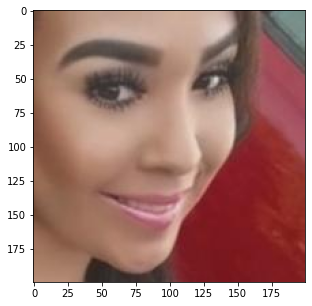

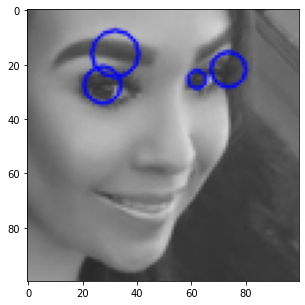

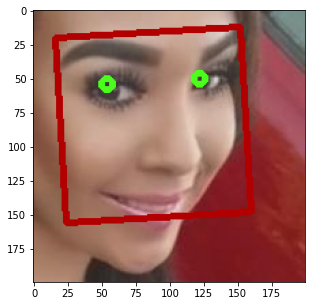

In [ ]:
#single check
d = {
    "Original":True,
    "Skin Mask":False,
    "Contours":False,
    "Face":False,
    "Blob Thresholds":False,
    "Blobs":True,
    "Eye Candidates":False,
    "Rotated Faces":False,
    "Template Matched Shifts":False,
    "Template Matched Eyes":False,
    "Annotations":False,
    "Output":True   
}

eyes, original_img, landmarks = detect_face(display_any=d, display_all=False)
#annotate_eyes(original_img, landmarks)
c = check_correct(eyes, landmarks)
c

In [ ]:
%%time

#run many checks
r1 = np.array(check_true_faces())  # Takes 16 minutes to run
r2 = np.array(check_not_faces()) 

fn = len(r1[r1==False]) / len(r1)  #percent of true faces labeled wrong
fp = len(r2[r2==False]) / len(r2)  #percent of non faces labeled as faces

print("False Negative Rate:", fn)
print("False Positive Rate:", fp)

Detecting Round 0
Face Seed: 2282
1  possible sets of eyes
Detecting Round 1
Face Seed: 518
1  possible sets of eyes
Detecting Round 2
Face Seed: 3036
0  possible sets of eyes
No Faces Detected
Detecting Round 3
Face Seed: 1890
4  possible sets of eyes
Detecting Round 4
Face Seed: 4674
3  possible sets of eyes
Detecting Round 5
Face Seed: 4189
6  possible sets of eyes
Detecting Round 6
Face Seed: 202
1  possible sets of eyes
Detecting Round 7
Face Seed: 5135
1  possible sets of eyes
Detecting Round 8
Face Seed: 5096
6  possible sets of eyes
Detecting Round 9
Face Seed: 2385
10  possible sets of eyes
Detecting Round 10
Face Seed: 6836
1  possible sets of eyes
Detecting Round 11
Face Seed: 5349
0  possible sets of eyes
No Faces Detected
Detecting Round 12
Face Seed: 2290
1  possible sets of eyes
Detecting Round 13
Face Seed: 951
2  possible sets of eyes
Detecting Round 14
Face Seed: 4095
1  possible sets of eyes
Detecting Round 15
Face Seed: 4685
0  possible sets of eyes
No Faces Detecte

Face Seed: 2539
0  possible sets of eyes
No Faces Detected
Detecting Round 128
Face Seed: 5467
2  possible sets of eyes
Detecting Round 129
Face Seed: 3794
4  possible sets of eyes
Detecting Round 130
Face Seed: 5098
0  possible sets of eyes
No Faces Detected
Detecting Round 131
Face Seed: 5611
0  possible sets of eyes
No Faces Detected
Detecting Round 132
Face Seed: 2835
2  possible sets of eyes
Detecting Round 133
Face Seed: 1776
0  possible sets of eyes
No Faces Detected
Detecting Round 134
Face Seed: 1073
0  possible sets of eyes
No Faces Detected
Detecting Round 135
Face Seed: 6810
1  possible sets of eyes
Detecting Round 136
Face Seed: 1958
3  possible sets of eyes
Detecting Round 137
Face Seed: 5580
0  possible sets of eyes
No Faces Detected
Detecting Round 138
Face Seed: 2396
1  possible sets of eyes
Detecting Round 139
Face Seed: 1666
2  possible sets of eyes
Detecting Round 140
Face Seed: 5266
2  possible sets of eyes
Detecting Round 141
Face Seed: 21
2  possible sets of eyes

Face Seed: 1908
4  possible sets of eyes
Detecting Round 258
Face Seed: 302
0  possible sets of eyes
No Faces Detected
Detecting Round 259
Face Seed: 1188
1  possible sets of eyes
Detecting Round 260
Face Seed: 6060
1  possible sets of eyes
Detecting Round 261
Face Seed: 5670
4  possible sets of eyes
Detecting Round 262
Face Seed: 344
1  possible sets of eyes
Detecting Round 263
Face Seed: 4500
4  possible sets of eyes
Detecting Round 264
Face Seed: 1239
2  possible sets of eyes
Detecting Round 265
Face Seed: 5581
0  possible sets of eyes
No Faces Detected
Detecting Round 266
Face Seed: 2686
2  possible sets of eyes
Detecting Round 267
Face Seed: 6880
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 268
Face Seed: 4854
7  possible sets of eyes
Detecting Round 269
Face Seed: 5942
9  possible sets of eyes
Detecting Round 270
Face Seed: 5631
3  possible sets of eyes
Detecting Round 271
Face Seed: 3204
2  possible sets of eyes
Detecti

Face Seed: 1712
2  possible sets of eyes
Detecting Round 385
Face Seed: 2658
3  possible sets of eyes
Detecting Round 386
Face Seed: 2060
1  possible sets of eyes
Detecting Round 387
Face Seed: 3872
8  possible sets of eyes
Detecting Round 388
Face Seed: 2128
6  possible sets of eyes
Detecting Round 389
Face Seed: 646
1  possible sets of eyes
Detecting Round 390
Face Seed: 4550
0  possible sets of eyes
No Faces Detected
Detecting Round 391
Face Seed: 649
1  possible sets of eyes
Detecting Round 392
Face Seed: 884
1  possible sets of eyes
Detecting Round 393
Face Seed: 3854
0  possible sets of eyes
No Faces Detected
Detecting Round 394
Face Seed: 3464
2  possible sets of eyes
Detecting Round 395
Face Seed: 6989
1  possible sets of eyes
Detecting Round 396
Face Seed: 5835
3  possible sets of eyes
Detecting Round 397
Face Seed: 355
1  possible sets of eyes
Detecting Round 398
Face Seed: 3117
2  possible sets of eyes
Detecting Round 399
Face Seed: 4753
0  possible sets of eyes
No Faces Det

Face Seed: 7043
2  possible sets of eyes
Detecting Round 511
Face Seed: 5874
2  possible sets of eyes
Detecting Round 512
Face Seed: 1606
2  possible sets of eyes
Detecting Round 513
Face Seed: 1505
0  possible sets of eyes
No Faces Detected
Detecting Round 514
Face Seed: 490
1  possible sets of eyes
Detecting Round 515
Face Seed: 6182
5  possible sets of eyes
Detecting Round 516
Face Seed: 128
7  possible sets of eyes
Detecting Round 517
Face Seed: 956
1  possible sets of eyes
Detecting Round 518
Face Seed: 3017
8  possible sets of eyes
Detecting Round 519
Face Seed: 1106
1  possible sets of eyes
Detecting Round 520
Face Seed: 1057
0  possible sets of eyes
No Faces Detected
Detecting Round 521
Face Seed: 4928
1  possible sets of eyes
Detecting Round 522
Face Seed: 4681
2  possible sets of eyes
Detecting Round 523
Face Seed: 2265
4  possible sets of eyes
Detecting Round 524
Face Seed: 262
1  possible sets of eyes
Detecting Round 525
Face Seed: 879
1  possible sets of eyes
Detecting Rou

Face Seed: 490
1  possible sets of eyes
Detecting Round 640
Face Seed: 658
1  possible sets of eyes
Detecting Round 641
Face Seed: 4484
0  possible sets of eyes
No Faces Detected
Detecting Round 642
Face Seed: 4092
4  possible sets of eyes
Detecting Round 643
Face Seed: 2163
1  possible sets of eyes
Detecting Round 644
Face Seed: 2406
6  possible sets of eyes
Detecting Round 645
Face Seed: 5643
0  possible sets of eyes
No Faces Detected
Detecting Round 646
Face Seed: 4013
1  possible sets of eyes
Detecting Round 647
Face Seed: 5856
2  possible sets of eyes
Detecting Round 648
Face Seed: 2999
10  possible sets of eyes
Detecting Round 649
Face Seed: 1780
1  possible sets of eyes
Detecting Round 650
Face Seed: 2840
2  possible sets of eyes
Detecting Round 651
Face Seed: 5015
2  possible sets of eyes
Detecting Round 652
Face Seed: 5882
0  possible sets of eyes
No Faces Detected
Detecting Round 653
Face Seed: 1918
1  possible sets of eyes
Detecting Round 654
Face Seed: 5104
1  possible sets

Face Seed: 4278
1  possible sets of eyes
Detecting Round 767
Face Seed: 6707
16  possible sets of eyes
Detecting Round 768
Face Seed: 4103
4  possible sets of eyes
Detecting Round 769
Face Seed: 349
1  possible sets of eyes
Detecting Round 770
Face Seed: 5838
2  possible sets of eyes
Detecting Round 771
Face Seed: 4430
3  possible sets of eyes
Detecting Round 772
Face Seed: 6872
1  possible sets of eyes
Detecting Round 773
Face Seed: 3215
2  possible sets of eyes
Detecting Round 774
Face Seed: 3140
0  possible sets of eyes
No Faces Detected
Detecting Round 775
Face Seed: 6502
0  possible sets of eyes
No Faces Detected
Detecting Round 776
Face Seed: 538
1  possible sets of eyes
Detecting Round 777
Face Seed: 536
3  possible sets of eyes
Detecting Round 778
Face Seed: 709
1  possible sets of eyes
Detecting Round 779
Face Seed: 974
1  possible sets of eyes
Detecting Round 780
Face Seed: 1424
5  possible sets of eyes
Detecting Round 781
Face Seed: 4548
0  possible sets of eyes
No Faces Det

Face Seed: 4066
2  possible sets of eyes
Detecting Round 894
Face Seed: 2947
1  possible sets of eyes
Detecting Round 895
Face Seed: 3760
0  possible sets of eyes
No Faces Detected
Detecting Round 896
Face Seed: 136
1  possible sets of eyes
Detecting Round 897
Face Seed: 4143
1  possible sets of eyes
Detecting Round 898
Face Seed: 6814
0  possible sets of eyes
No Faces Detected
Detecting Round 899
Face Seed: 4954
1  possible sets of eyes
Detecting Round 900
Face Seed: 644
1  possible sets of eyes
Detecting Round 901
Face Seed: 3929
1  possible sets of eyes
Detecting Round 902
Face Seed: 6548
1  possible sets of eyes
Detecting Round 903
Face Seed: 4724
0  possible sets of eyes
No Faces Detected
Detecting Round 904
Face Seed: 6185
2  possible sets of eyes
Detecting Round 905
Face Seed: 1282
2  possible sets of eyes
Detecting Round 906
Face Seed: 630
2  possible sets of eyes
Detecting Round 907
Face Seed: 5133
1  possible sets of eyes
Detecting Round 908
Face Seed: 5672
5  possible sets o

Face Seed: 4549
4  possible sets of eyes
Detecting Round 1021
Face Seed: 6920
0  possible sets of eyes
No Faces Detected
Detecting Round 1022
Face Seed: 3778
6  possible sets of eyes
Detecting Round 1023
Face Seed: 5083
1  possible sets of eyes
Detecting Round 1024
Face Seed: 1250
1  possible sets of eyes
Detecting Round 1025
Face Seed: 2073
2  possible sets of eyes
Detecting Round 1026
Face Seed: 1121
1  possible sets of eyes
Detecting Round 1027
Face Seed: 419
1  possible sets of eyes
Detecting Round 1028
Face Seed: 5883
1  possible sets of eyes
Detecting Round 1029
Face Seed: 1650
2  possible sets of eyes
Detecting Round 1030
Face Seed: 5043
0  possible sets of eyes
No Faces Detected
Detecting Round 1031
Face Seed: 2898
2  possible sets of eyes
Detecting Round 1032
Face Seed: 4945
1  possible sets of eyes
Detecting Round 1033
Face Seed: 3250
1  possible sets of eyes
Detecting Round 1034
Face Seed: 2549
2  possible sets of eyes
Detecting Round 1035
Face Seed: 3477
1  possible sets of

Face Seed: 4524
2  possible sets of eyes
Detecting Round 1147
Face Seed: 5411
1  possible sets of eyes
Detecting Round 1148
Face Seed: 5805
0  possible sets of eyes
No Faces Detected
Detecting Round 1149
Face Seed: 1435
5  possible sets of eyes
Detecting Round 1150
Face Seed: 334
2  possible sets of eyes
Detecting Round 1151
Face Seed: 6692
0  possible sets of eyes
No Faces Detected
Detecting Round 1152
Face Seed: 5565
9  possible sets of eyes
Detecting Round 1153
Face Seed: 6322
4  possible sets of eyes
Detecting Round 1154
Face Seed: 5086
3  possible sets of eyes
Detecting Round 1155
Face Seed: 1305
2  possible sets of eyes
Detecting Round 1156
Face Seed: 5921
1  possible sets of eyes
Detecting Round 1157
Face Seed: 2895
0  possible sets of eyes
No Faces Detected
Detecting Round 1158
Face Seed: 1646
1  possible sets of eyes
Detecting Round 1159
Face Seed: 5746
5  possible sets of eyes
Detecting Round 1160
Face Seed: 3503
1  possible sets of eyes
Detecting Round 1161
Face Seed: 4228
2

Face Seed: 6043
1  possible sets of eyes
Detecting Round 1272
Face Seed: 1
6  possible sets of eyes
Detecting Round 1273
Face Seed: 3413
1  possible sets of eyes
Detecting Round 1274
Face Seed: 1721
0  possible sets of eyes
No Faces Detected
Detecting Round 1275
Face Seed: 2554
4  possible sets of eyes
Detecting Round 1276
Face Seed: 4944
1  possible sets of eyes
Detecting Round 1277
Face Seed: 3777
7  possible sets of eyes
Detecting Round 1278
Face Seed: 3281
0  possible sets of eyes
No Faces Detected
Detecting Round 1279
Face Seed: 3052
4  possible sets of eyes
Detecting Round 1280
Face Seed: 5146
1  possible sets of eyes
Detecting Round 1281
Face Seed: 1840
3  possible sets of eyes
Detecting Round 1282
Face Seed: 5640
0  possible sets of eyes
No Faces Detected
Detecting Round 1283
Face Seed: 3764
1  possible sets of eyes
Detecting Round 1284
Face Seed: 763
2  possible sets of eyes
Detecting Round 1285
Face Seed: 5039
1  possible sets of eyes
Detecting Round 1286
Face Seed: 438
2  po

Face Seed: 2342
4  possible sets of eyes
Detecting Round 1399
Face Seed: 5789
4  possible sets of eyes
Detecting Round 1400
Face Seed: 2541
0  possible sets of eyes
No Faces Detected
Detecting Round 1401
Face Seed: 5823
0  possible sets of eyes
No Faces Detected
Detecting Round 1402
Face Seed: 2596
0  possible sets of eyes
No Faces Detected
Detecting Round 1403
Face Seed: 493
1  possible sets of eyes
Detecting Round 1404
Face Seed: 888
1  possible sets of eyes
Detecting Round 1405
Face Seed: 5453
1  possible sets of eyes
Detecting Round 1406
Face Seed: 1736
2  possible sets of eyes
Detecting Round 1407
Face Seed: 110
4  possible sets of eyes
Detecting Round 1408
Face Seed: 6161
1  possible sets of eyes
Detecting Round 1409
Face Seed: 1598
1  possible sets of eyes
Detecting Round 1410
Face Seed: 77
1  possible sets of eyes
Detecting Round 1411
Face Seed: 293
1  possible sets of eyes
Detecting Round 1412
Face Seed: 1211
1  possible sets of eyes
Detecting Round 1413
Face Seed: 3014
0  pos

Face Seed: 1794
2  possible sets of eyes
Detecting Round 1526
Face Seed: 1042
1  possible sets of eyes
Detecting Round 1527
Face Seed: 6093
6  possible sets of eyes
Detecting Round 1528
Face Seed: 6366
1  possible sets of eyes
Detecting Round 1529
Face Seed: 3783
1  possible sets of eyes
Detecting Round 1530
Face Seed: 1804
4  possible sets of eyes
Detecting Round 1531
Face Seed: 5539
2  possible sets of eyes
Detecting Round 1532
Face Seed: 3140
0  possible sets of eyes
No Faces Detected
Detecting Round 1533
Face Seed: 1889
1  possible sets of eyes
Detecting Round 1534
Face Seed: 1335
3  possible sets of eyes
Detecting Round 1535
Face Seed: 4812
2  possible sets of eyes
Detecting Round 1536
Face Seed: 6309
8  possible sets of eyes
Detecting Round 1537
Face Seed: 3788
6  possible sets of eyes
Detecting Round 1538
Face Seed: 4490
0  possible sets of eyes
No Faces Detected
Detecting Round 1539
Face Seed: 6841
4  possible sets of eyes
Detecting Round 1540
Face Seed: 4705
1  possible sets o

Face Seed: 4219
10  possible sets of eyes
Detecting Round 1650
Face Seed: 2468
2  possible sets of eyes
Detecting Round 1651
Face Seed: 2646
0  possible sets of eyes
No Faces Detected
Detecting Round 1652
Face Seed: 6896
2  possible sets of eyes
Detecting Round 1653
Face Seed: 490
1  possible sets of eyes
Detecting Round 1654
Face Seed: 846
2  possible sets of eyes
Detecting Round 1655
Face Seed: 2797
4  possible sets of eyes
Detecting Round 1656
Face Seed: 1927
6  possible sets of eyes
Detecting Round 1657
Face Seed: 6274
2  possible sets of eyes
Detecting Round 1658
Face Seed: 4616
1  possible sets of eyes
Detecting Round 1659
Face Seed: 6294
0  possible sets of eyes
No Faces Detected
Detecting Round 1660
Face Seed: 41
2  possible sets of eyes
Detecting Round 1661
Face Seed: 2420
1  possible sets of eyes
Detecting Round 1662
Face Seed: 4529
1  possible sets of eyes
Detecting Round 1663
Face Seed: 1647
1  possible sets of eyes
Detecting Round 1664
Face Seed: 5603
1  possible sets of e

Face Seed: 3349
5  possible sets of eyes
Detecting Round 1778
Face Seed: 3492
2  possible sets of eyes
Detecting Round 1779
Face Seed: 6793
1  possible sets of eyes
Detecting Round 1780
Face Seed: 3667
1  possible sets of eyes
Detecting Round 1781
Face Seed: 2188
3  possible sets of eyes
Detecting Round 1782
Face Seed: 104
1  possible sets of eyes
Detecting Round 1783
Face Seed: 2015
0  possible sets of eyes
No Faces Detected
Detecting Round 1784
Face Seed: 3753
0  possible sets of eyes
No Faces Detected
Detecting Round 1785
Face Seed: 1830
7  possible sets of eyes
Detecting Round 1786
Face Seed: 5887
9  possible sets of eyes
Detecting Round 1787
Face Seed: 4097
1  possible sets of eyes
Detecting Round 1788
Face Seed: 6675
1  possible sets of eyes
Detecting Round 1789
Face Seed: 6528
3  possible sets of eyes
Detecting Round 1790
Face Seed: 5096
6  possible sets of eyes
Detecting Round 1791
Face Seed: 3865
5  possible sets of eyes
Detecting Round 1792
Face Seed: 5415
1  possible sets of

Face Seed: 2079
1  possible sets of eyes
Detecting Round 1904
Face Seed: 3841
1  possible sets of eyes
Detecting Round 1905
Face Seed: 1079
1  possible sets of eyes
Detecting Round 1906
Face Seed: 2495
1  possible sets of eyes
Detecting Round 1907
Face Seed: 4450
2  possible sets of eyes
Detecting Round 1908
Face Seed: 4617
1  possible sets of eyes
Detecting Round 1909
Face Seed: 5550
2  possible sets of eyes
Detecting Round 1910
Face Seed: 1880
1  possible sets of eyes
Detecting Round 1911
Face Seed: 2753
1  possible sets of eyes
Detecting Round 1912
Face Seed: 6648
2  possible sets of eyes
Detecting Round 1913
Face Seed: 1888
0  possible sets of eyes
No Faces Detected
Detecting Round 1914
Face Seed: 4530
7  possible sets of eyes
Detecting Round 1915
Face Seed: 3436
4  possible sets of eyes
Detecting Round 1916
Face Seed: 4509
3  possible sets of eyes
Detecting Round 1917
Face Seed: 3812
1  possible sets of eyes
Detecting Round 1918
Face Seed: 3185
8  possible sets of eyes
Detecting R

Face Seed: 771
1  possible sets of eyes
Detecting Round 2032
Face Seed: 5398
2  possible sets of eyes
Detecting Round 2033
Face Seed: 5395
1  possible sets of eyes
Detecting Round 2034
Face Seed: 903
1  possible sets of eyes
Detecting Round 2035
Face Seed: 2454
4  possible sets of eyes
Detecting Round 2036
Face Seed: 874
1  possible sets of eyes
Detecting Round 2037
Face Seed: 1790
3  possible sets of eyes
Detecting Round 2038
Face Seed: 1799
0  possible sets of eyes
No Faces Detected
Detecting Round 2039
Face Seed: 3895
1  possible sets of eyes
Detecting Round 2040
Face Seed: 5945
0  possible sets of eyes
No Faces Detected
Detecting Round 2041
Face Seed: 984
3  possible sets of eyes
Detecting Round 2042
Face Seed: 3487
8  possible sets of eyes
Detecting Round 2043
Face Seed: 3469
0  possible sets of eyes
No Faces Detected
Detecting Round 2044
Face Seed: 930
1  possible sets of eyes
Detecting Round 2045
Face Seed: 3210
1  possible sets of eyes
Detecting Round 2046
Face Seed: 865
2  pos

Face Seed: 851
1  possible sets of eyes
Detecting Round 2157
Face Seed: 4485
3  possible sets of eyes
Detecting Round 2158
Face Seed: 6753
2  possible sets of eyes
Detecting Round 2159
Face Seed: 6393
1  possible sets of eyes
Detecting Round 2160
Face Seed: 814
1  possible sets of eyes
Detecting Round 2161
Face Seed: 3777
7  possible sets of eyes
Detecting Round 2162
Face Seed: 4231
1  possible sets of eyes
Detecting Round 2163
Face Seed: 2377
3  possible sets of eyes
Detecting Round 2164
Face Seed: 1011
1  possible sets of eyes
Detecting Round 2165
Face Seed: 895
1  possible sets of eyes
Detecting Round 2166
Face Seed: 1936
1  possible sets of eyes
Detecting Round 2167
Face Seed: 93
1  possible sets of eyes
Detecting Round 2168
Face Seed: 5500
4  possible sets of eyes
Detecting Round 2169
Face Seed: 6917
16  possible sets of eyes
Detecting Round 2170
Face Seed: 862
2  possible sets of eyes
Detecting Round 2171
Face Seed: 45
1  possible sets of eyes
Detecting Round 2172
Face Seed: 181


Face Seed: 2651
1  possible sets of eyes
Detecting Round 2283
Face Seed: 4417
0  possible sets of eyes
No Faces Detected
Detecting Round 2284
Face Seed: 5147
Error: no contours. Using whole image as face
1  possible sets of eyes
Detecting Round 2285
Face Seed: 6832
0  possible sets of eyes
No Faces Detected
Detecting Round 2286
Face Seed: 1415
3  possible sets of eyes
Detecting Round 2287
Face Seed: 353
0  possible sets of eyes
No Faces Detected
Detecting Round 2288
Face Seed: 4511
4  possible sets of eyes
Detecting Round 2289
Face Seed: 2010
1  possible sets of eyes
Detecting Round 2290
Face Seed: 5168
1  possible sets of eyes
Detecting Round 2291
Face Seed: 3569
1  possible sets of eyes
Detecting Round 2292
Face Seed: 5581
0  possible sets of eyes
No Faces Detected
Detecting Round 2293
Face Seed: 5844
1  possible sets of eyes
Detecting Round 2294
Face Seed: 1209
1  possible sets of eyes
Detecting Round 2295
Face Seed: 3105
2  possible sets of eyes
Detecting Round 2296
Face Seed: 1570

Face Seed: 3368
0  possible sets of eyes
No Faces Detected
Detecting Round 2409
Face Seed: 1734
3  possible sets of eyes
Detecting Round 2410
Face Seed: 4633
1  possible sets of eyes
Detecting Round 2411
Face Seed: 4491
0  possible sets of eyes
No Faces Detected
Detecting Round 2412
Face Seed: 6399
0  possible sets of eyes
No Faces Detected
Detecting Round 2413
Face Seed: 3878
1  possible sets of eyes
Detecting Round 2414
Face Seed: 2184
0  possible sets of eyes
No Faces Detected
Detecting Round 2415
Face Seed: 707
2  possible sets of eyes
Detecting Round 2416
Face Seed: 1601
3  possible sets of eyes
Detecting Round 2417
Face Seed: 4987
1  possible sets of eyes
Detecting Round 2418
Face Seed: 2075
0  possible sets of eyes
No Faces Detected
Detecting Round 2419
Face Seed: 2033
0  possible sets of eyes
No Faces Detected
Detecting Round 2420
Face Seed: 1659
6  possible sets of eyes
Detecting Round 2421
Face Seed: 5531
0  possible sets of eyes
No Faces Detected
Detecting Round 2422
Face Se

0  possible sets of eyes
No Faces Detected
Detecting Round 2534
Face Seed: 5109
1  possible sets of eyes
Detecting Round 2535
Face Seed: 3346
10  possible sets of eyes
Detecting Round 2536
Face Seed: 4042
3  possible sets of eyes
Detecting Round 2537
Face Seed: 3934
2  possible sets of eyes
Detecting Round 2538
Face Seed: 2796
0  possible sets of eyes
No Faces Detected
Detecting Round 2539
Face Seed: 4377
7  possible sets of eyes
Detecting Round 2540
Face Seed: 6109
1  possible sets of eyes
Detecting Round 2541
Face Seed: 5017
Error: no contours. Using whole image as face
1  possible sets of eyes
Detecting Round 2542
Face Seed: 2031
2  possible sets of eyes
Detecting Round 2543
Face Seed: 5549
12  possible sets of eyes
Detecting Round 2544
Face Seed: 5578
1  possible sets of eyes
Detecting Round 2545
Face Seed: 1768
3  possible sets of eyes
Detecting Round 2546
Face Seed: 6981
0  possible sets of eyes
No Faces Detected
Detecting Round 2547
Face Seed: 2969
2  possible sets of eyes
Detec

Face Seed: 3692
1  possible sets of eyes
Detecting Round 2660
Face Seed: 1117
2  possible sets of eyes
Detecting Round 2661
Face Seed: 1235
1  possible sets of eyes
Detecting Round 2662
Face Seed: 2064
3  possible sets of eyes
Detecting Round 2663
Face Seed: 574
2  possible sets of eyes
Detecting Round 2664
Face Seed: 1386
2  possible sets of eyes
Detecting Round 2665
Face Seed: 5343
1  possible sets of eyes
Detecting Round 2666
Face Seed: 2671
1  possible sets of eyes
Detecting Round 2667
Face Seed: 5934
Error: no contours. Using whole image as face
2  possible sets of eyes
Detecting Round 2668
Face Seed: 2201
9  possible sets of eyes
Detecting Round 2669
Face Seed: 4685
0  possible sets of eyes
No Faces Detected
Detecting Round 2670
Face Seed: 492
1  possible sets of eyes
Detecting Round 2671
Face Seed: 4106
2  possible sets of eyes
Detecting Round 2672
Face Seed: 5166
1  possible sets of eyes
Detecting Round 2673
Face Seed: 6636
10  possible sets of eyes
Detecting Round 2674
Face Se

Face Seed: 987
1  possible sets of eyes
Detecting Round 2788
Face Seed: 3923
4  possible sets of eyes
Detecting Round 2789
Face Seed: 6564
11  possible sets of eyes
Detecting Round 2790
Face Seed: 3530
3  possible sets of eyes
Detecting Round 2791
Face Seed: 3893
2  possible sets of eyes
Detecting Round 2792
Face Seed: 4252
1  possible sets of eyes
Detecting Round 2793
Face Seed: 2397
0  possible sets of eyes
No Faces Detected
Detecting Round 2794
Face Seed: 6295
1  possible sets of eyes
Detecting Round 2795
Face Seed: 6969
1  possible sets of eyes
Detecting Round 2796
Face Seed: 6620
4  possible sets of eyes
Detecting Round 2797
Face Seed: 6358
10  possible sets of eyes
Detecting Round 2798
Face Seed: 2634
4  possible sets of eyes
Detecting Round 2799
Face Seed: 5254
4  possible sets of eyes
Detecting Round 2800
Face Seed: 392
4  possible sets of eyes
Detecting Round 2801
Face Seed: 2633
0  possible sets of eyes
No Faces Detected
Detecting Round 2802
Face Seed: 604
0  possible sets of

2  possible sets of eyes
Detecting Round 2914
Face Seed: 2684
0  possible sets of eyes
No Faces Detected
Detecting Round 2915
Face Seed: 3289
0  possible sets of eyes
No Faces Detected
Detecting Round 2916
Face Seed: 1250
1  possible sets of eyes
Detecting Round 2917
Face Seed: 2911
4  possible sets of eyes
Detecting Round 2918
Face Seed: 1031
1  possible sets of eyes
Detecting Round 2919
Face Seed: 5241
9  possible sets of eyes
Detecting Round 2920
Face Seed: 3787
1  possible sets of eyes
Detecting Round 2921
Face Seed: 3440
1  possible sets of eyes
Detecting Round 2922
Face Seed: 2901
5  possible sets of eyes
Detecting Round 2923
Face Seed: 3275
2  possible sets of eyes
Detecting Round 2924
Face Seed: 4275
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2925
Face Seed: 844
1  possible sets of eyes
Detecting Round 2926
Face Seed: 4978
1  possible sets of eyes
Detecting Round 2927
Face Seed: 3675
1  possible sets of eyes
Detectin

Detecting Round 70
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 71
0  possible sets of eyes
No Faces Detected
Detecting Round 72
0  possible sets of eyes
No Faces Detected
Detecting Round 73
0  possible sets of eyes
No Faces Detected
Detecting Round 74
0  possible sets of eyes
No Faces Detected
Detecting Round 75
0  possible sets of eyes
No Faces Detected
Detecting Round 76
0  possible sets of eyes
No Faces Detected
Detecting Round 77
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 78
0  possible sets of eyes
No Faces Detected
Detecting Round 79
0  possible sets of eyes
No Faces Detected
Detecting Round 80
0  possible sets of eyes
No Faces Detected
Detecting Round 81
0  possible sets of eyes
No Faces Detected
Detecting Round 82
0  possible sets of eyes
No Faces Detected
Detecting Round 83
0  possible sets of eyes
No Faces Detected
Detecting Round 84
0  possible sets of e

0  possible sets of eyes
No Faces Detected
Detecting Round 207
0  possible sets of eyes
No Faces Detected
Detecting Round 208
0  possible sets of eyes
No Faces Detected
Detecting Round 209
0  possible sets of eyes
No Faces Detected
Detecting Round 210
0  possible sets of eyes
No Faces Detected
Detecting Round 211
0  possible sets of eyes
No Faces Detected
Detecting Round 212
0  possible sets of eyes
No Faces Detected
Detecting Round 213
0  possible sets of eyes
No Faces Detected
Detecting Round 214
0  possible sets of eyes
No Faces Detected
Detecting Round 215
0  possible sets of eyes
No Faces Detected
Detecting Round 216
0  possible sets of eyes
No Faces Detected
Detecting Round 217
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 218
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 219
0  possible sets of eyes
No Faces Detected
Detecting Round 220
0  possible sets of eyes
No Faces Detec

0  possible sets of eyes
No Faces Detected
Detecting Round 334
0  possible sets of eyes
No Faces Detected
Detecting Round 335
0  possible sets of eyes
No Faces Detected
Detecting Round 336
0  possible sets of eyes
No Faces Detected
Detecting Round 337
0  possible sets of eyes
No Faces Detected
Detecting Round 338
0  possible sets of eyes
No Faces Detected
Detecting Round 339
0  possible sets of eyes
No Faces Detected
Detecting Round 340
0  possible sets of eyes
No Faces Detected
Detecting Round 341
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 342
0  possible sets of eyes
No Faces Detected
Detecting Round 343
0  possible sets of eyes
No Faces Detected
Detecting Round 344
0  possible sets of eyes
No Faces Detected
Detecting Round 345
0  possible sets of eyes
No Faces Detected
Detecting Round 346
0  possible sets of eyes
No Faces Detected
Detecting Round 347
0  possible sets of eyes
No Faces Detected
Detecting Round 348
Error: no

Error: no good alignment, using original alignment
Detecting Round 488
0  possible sets of eyes
No Faces Detected
Detecting Round 489
0  possible sets of eyes
No Faces Detected
Detecting Round 490
0  possible sets of eyes
No Faces Detected
Detecting Round 491
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 492
0  possible sets of eyes
No Faces Detected
Detecting Round 493
0  possible sets of eyes
No Faces Detected
Detecting Round 494
0  possible sets of eyes
No Faces Detected
Detecting Round 495
0  possible sets of eyes
No Faces Detected
Detecting Round 496
0  possible sets of eyes
No Faces Detected
Detecting Round 497
0  possible sets of eyes
No Faces Detected
Detecting Round 498
0  possible sets of eyes
No Faces Detected
Detecting Round 499
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 500
0  possible sets of eyes
No Faces Detected
Detecting Round 501
0  possible sets o

0  possible sets of eyes
No Faces Detected
Detecting Round 659
0  possible sets of eyes
No Faces Detected
Detecting Round 660
0  possible sets of eyes
No Faces Detected
Detecting Round 661
0  possible sets of eyes
No Faces Detected
Detecting Round 662
0  possible sets of eyes
No Faces Detected
Detecting Round 663
0  possible sets of eyes
No Faces Detected
Detecting Round 664
0  possible sets of eyes
No Faces Detected
Detecting Round 665
0  possible sets of eyes
No Faces Detected
Detecting Round 666
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 667
0  possible sets of eyes
No Faces Detected
Detecting Round 668
0  possible sets of eyes
No Faces Detected
Detecting Round 669
0  possible sets of eyes
No Faces Detected
Detecting Round 670
0  possible sets of eyes
No Faces Detected
Detecting Round 671
0  possible sets of eyes
No Faces Detected
Detecting Round 672
0  possible sets of eyes
No Faces Detected
Detecting Round 673
0  possible sets of ey

0  possible sets of eyes
No Faces Detected
Detecting Round 836
0  possible sets of eyes
No Faces Detected
Detecting Round 837
0  possible sets of eyes
No Faces Detected
Detecting Round 838
0  possible sets of eyes
No Faces Detected
Detecting Round 839
0  possible sets of eyes
No Faces Detected
Detecting Round 840
0  possible sets of eyes
No Faces Detected
Detecting Round 841
0  possible sets of eyes
No Faces Detected
Detecting Round 842
0  possible sets of eyes
No Faces Detected
Detecting Round 843
0  possible sets of eyes
No Faces Detected
Detecting Round 844
0  possible sets of eyes
No Faces Detected
Detecting Round 845
0  possible sets of eyes
No Faces Detected
Detecting Round 846
0  possible sets of eyes
No Faces Detected
Detecting Round 847
0  possible sets of eyes
No Faces Detected
Detecting Round 848
0  possible sets of eyes
No Faces Detected
Detecting Round 849
0  possible sets of eyes
No Faces Detected
Detecting Round 850
0  possible sets of eyes
No Faces Detected
Detecting Ro

0  possible sets of eyes
No Faces Detected
Detecting Round 988
0  possible sets of eyes
No Faces Detected
Detecting Round 989
0  possible sets of eyes
No Faces Detected
Detecting Round 990
0  possible sets of eyes
No Faces Detected
Detecting Round 991
0  possible sets of eyes
No Faces Detected
Detecting Round 992
0  possible sets of eyes
No Faces Detected
Detecting Round 993
0  possible sets of eyes
No Faces Detected
Detecting Round 994
0  possible sets of eyes
No Faces Detected
Detecting Round 995
0  possible sets of eyes
No Faces Detected
Detecting Round 996
0  possible sets of eyes
No Faces Detected
Detecting Round 997
0  possible sets of eyes
No Faces Detected
Detecting Round 998
0  possible sets of eyes
No Faces Detected
Detecting Round 999
0  possible sets of eyes
No Faces Detected
Detecting Round 1000
0  possible sets of eyes
No Faces Detected
Detecting Round 1001
0  possible sets of eyes
No Faces Detected
Detecting Round 1002
0  possible sets of eyes
No Faces Detected
Detecting

0  possible sets of eyes
No Faces Detected
Detecting Round 1166
0  possible sets of eyes
No Faces Detected
Detecting Round 1167
0  possible sets of eyes
No Faces Detected
Detecting Round 1168
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1169
0  possible sets of eyes
No Faces Detected
Detecting Round 1170
0  possible sets of eyes
No Faces Detected
Detecting Round 1171
0  possible sets of eyes
No Faces Detected
Detecting Round 1172
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 1173
0  possible sets of eyes
No Faces Detected
Detecting Round 1174
0  possible sets of eyes
No Faces Detected
Detecting Round 1175
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 1176
0  possible sets of eyes
No Faces Detected
Detecting Round 1177
0  possible sets of eyes
No Faces Detected
Detecting Round 1178
Error: no contours. Using whole image as face
0  possibl

Detecting Round 1350
0  possible sets of eyes
No Faces Detected
Detecting Round 1351
0  possible sets of eyes
No Faces Detected
Detecting Round 1352
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1353
0  possible sets of eyes
No Faces Detected
Detecting Round 1354
0  possible sets of eyes
No Faces Detected
Detecting Round 1355
0  possible sets of eyes
No Faces Detected
Detecting Round 1356
0  possible sets of eyes
No Faces Detected
Detecting Round 1357
0  possible sets of eyes
No Faces Detected
Detecting Round 1358
0  possible sets of eyes
No Faces Detected
Detecting Round 1359
0  possible sets of eyes
No Faces Detected
Detecting Round 1360
0  possible sets of eyes
No Faces Detected
Detecting Round 1361
0  possible sets of eyes
No Faces Detected
Detecting Round 1362
0  possible sets of eyes
No Faces Detected
Detecting Round 1363
0  possible sets of eyes
No Faces Detected
Detecting Round 1364
0  possible sets of eyes
No Faces Det

0  possible sets of eyes
No Faces Detected
Detecting Round 1512
0  possible sets of eyes
No Faces Detected
Detecting Round 1513
0  possible sets of eyes
No Faces Detected
Detecting Round 1514
0  possible sets of eyes
No Faces Detected
Detecting Round 1515
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1516
0  possible sets of eyes
No Faces Detected
Detecting Round 1517
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 1518
1  possible sets of eyes
Detecting Round 1519
0  possible sets of eyes
No Faces Detected
Detecting Round 1520
0  possible sets of eyes
No Faces Detected
Detecting Round 1521
0  possible sets of eyes
No Faces Detected
Detecting Round 1522
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1523
0  possible sets of eyes
No Faces Detected
Detecting Round 1524
Error: no contours. Using whole image as face
0  possible set

Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1670
0  possible sets of eyes
No Faces Detected
Detecting Round 1671
0  possible sets of eyes
No Faces Detected
Detecting Round 1672
0  possible sets of eyes
No Faces Detected
Detecting Round 1673
0  possible sets of eyes
No Faces Detected
Detecting Round 1674
0  possible sets of eyes
No Faces Detected
Detecting Round 1675
0  possible sets of eyes
No Faces Detected
Detecting Round 1676
0  possible sets of eyes
No Faces Detected
Detecting Round 1677
0  possible sets of eyes
No Faces Detected
Detecting Round 1678
0  possible sets of eyes
No Faces Detected
Detecting Round 1679
0  possible sets of eyes
No Faces Detected
Detecting Round 1680
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1681
0  possible sets of eyes
No Faces Detected
Detecting Round 1682
0  possible sets of eyes
No Faces Detected
Detecting Round 1683
0  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 1865
0  possible sets of eyes
No Faces Detected
Detecting Round 1866
0  possible sets of eyes
No Faces Detected
Detecting Round 1867
0  possible sets of eyes
No Faces Detected
Detecting Round 1868
0  possible sets of eyes
No Faces Detected
Detecting Round 1869
0  possible sets of eyes
No Faces Detected
Detecting Round 1870
0  possible sets of eyes
No Faces Detected
Detecting Round 1871
0  possible sets of eyes
No Faces Detected
Detecting Round 1872
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 1873
0  possible sets of eyes
No Faces Detected
Detecting Round 1874
0  possible sets of eyes
No Faces Detected
Detecting Round 1875
0  possible sets of eyes
No Faces Detected
Detecting Round 1876
0  possible sets of eyes
No Faces Detected
Detecting Round 1877
0  possible sets of eyes
No Faces Detected
Detecting Round 1878
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 2027
0  possible sets of eyes
No Faces Detected
Detecting Round 2028
0  possible sets of eyes
No Faces Detected
Detecting Round 2029
0  possible sets of eyes
No Faces Detected
Detecting Round 2030
0  possible sets of eyes
No Faces Detected
Detecting Round 2031
0  possible sets of eyes
No Faces Detected
Detecting Round 2032
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2033
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 2034
0  possible sets of eyes
No Faces Detected
Detecting Round 2035
0  possible sets of eyes
No Faces Detected
Detecting Round 2036
0  possible sets of eyes
No Faces Detected
Detecting Round 2037
0  possible sets of eyes
No Faces Detected
Detecting Round 2038
0  possible sets of eyes
No Faces Detected
Detecting Round 2039
0  possible sets of eyes
No Faces Detected
Detecting Round 2040
0  possible sets of eyes


Detecting Round 2183
0  possible sets of eyes
No Faces Detected
Detecting Round 2184
0  possible sets of eyes
No Faces Detected
Detecting Round 2185
0  possible sets of eyes
No Faces Detected
Detecting Round 2186
0  possible sets of eyes
No Faces Detected
Detecting Round 2187
0  possible sets of eyes
No Faces Detected
Detecting Round 2188
0  possible sets of eyes
No Faces Detected
Detecting Round 2189
0  possible sets of eyes
No Faces Detected
Detecting Round 2190
0  possible sets of eyes
No Faces Detected
Detecting Round 2191
0  possible sets of eyes
No Faces Detected
Detecting Round 2192
0  possible sets of eyes
No Faces Detected
Detecting Round 2193
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2194
0  possible sets of eyes
No Faces Detected
Detecting Round 2195
0  possible sets of eyes
No Faces Detected
Detecting Round 2196
0  possible sets of eyes
No Faces Detected
Detecting Round 2197
0  possible sets of eyes
No Faces Det

0  possible sets of eyes
No Faces Detected
Detecting Round 2373
0  possible sets of eyes
No Faces Detected
Detecting Round 2374
0  possible sets of eyes
No Faces Detected
Detecting Round 2375
0  possible sets of eyes
No Faces Detected
Detecting Round 2376
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 2377
0  possible sets of eyes
No Faces Detected
Detecting Round 2378
0  possible sets of eyes
No Faces Detected
Detecting Round 2379
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2380
0  possible sets of eyes
No Faces Detected
Detecting Round 2381
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2382
0  possible sets of eyes
No Faces Detected
Detecting Round 2383
0  possible sets of eyes
No Faces Detected
Detecting Round 2384
0  possible sets of eyes
No Faces Detected
Detecting Round 2385
0  possible sets of eyes
No Faces Detected


0  possible sets of eyes
No Faces Detected
Detecting Round 2565
0  possible sets of eyes
No Faces Detected
Detecting Round 2566
0  possible sets of eyes
No Faces Detected
Detecting Round 2567
0  possible sets of eyes
No Faces Detected
Detecting Round 2568
0  possible sets of eyes
No Faces Detected
Detecting Round 2569
0  possible sets of eyes
No Faces Detected
Detecting Round 2570
0  possible sets of eyes
No Faces Detected
Detecting Round 2571
0  possible sets of eyes
No Faces Detected
Detecting Round 2572
0  possible sets of eyes
No Faces Detected
Detecting Round 2573
0  possible sets of eyes
No Faces Detected
Detecting Round 2574
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2575
0  possible sets of eyes
No Faces Detected
Detecting Round 2576
0  possible sets of eyes
No Faces Detected
Detecting Round 2577
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2578
0  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 2757
0  possible sets of eyes
No Faces Detected
Detecting Round 2758
0  possible sets of eyes
No Faces Detected
Detecting Round 2759
0  possible sets of eyes
No Faces Detected
Detecting Round 2760
0  possible sets of eyes
No Faces Detected
Detecting Round 2761
0  possible sets of eyes
No Faces Detected
Detecting Round 2762
0  possible sets of eyes
No Faces Detected
Detecting Round 2763
0  possible sets of eyes
No Faces Detected
Detecting Round 2764
0  possible sets of eyes
No Faces Detected
Detecting Round 2765
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2766
0  possible sets of eyes
No Faces Detected
Detecting Round 2767
0  possible sets of eyes
No Faces Detected
Detecting Round 2768
0  possible sets of eyes
No Faces Detected
Detecting Round 2769
0  possible sets of eyes
No Faces Detected
Detecting Round 2770
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 2936
0  possible sets of eyes
No Faces Detected
Detecting Round 2937
0  possible sets of eyes
No Faces Detected
Detecting Round 2938
0  possible sets of eyes
No Faces Detected
Detecting Round 2939
0  possible sets of eyes
No Faces Detected
Detecting Round 2940
0  possible sets of eyes
No Faces Detected
Detecting Round 2941
0  possible sets of eyes
No Faces Detected
Detecting Round 2942
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 2943
0  possible sets of eyes
No Faces Detected
Detecting Round 2944
0  possible sets of eyes
No Faces Detected
Detecting Round 2945
0  possible sets of eyes
No Faces Detected
Detecting Round 2946
0  possible sets of eyes
No Faces Detected
Detecting Round 2947
0  possible sets of eyes
No Faces Detected
Detecting Round 2948
0  possible sets of eyes
No Faces Detected
Detecting Round 2949
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 3120
0  possible sets of eyes
No Faces Detected
Detecting Round 3121
0  possible sets of eyes
No Faces Detected
Detecting Round 3122
0  possible sets of eyes
No Faces Detected
Detecting Round 3123
0  possible sets of eyes
No Faces Detected
Detecting Round 3124
0  possible sets of eyes
No Faces Detected
Detecting Round 3125
0  possible sets of eyes
No Faces Detected
Detecting Round 3126
0  possible sets of eyes
No Faces Detected
Detecting Round 3127
0  possible sets of eyes
No Faces Detected
Detecting Round 3128
0  possible sets of eyes
No Faces Detected
Detecting Round 3129
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 3130
0  possible sets of eyes
No Faces Detected
Detecting Round 3131
0  possible sets of eyes
No Faces Detected
Detecting Round 3132
0  possible sets of eyes
No Faces Detected
Detecting Round 3133
0  possible sets of eyes
No Faces Detected
Detecting Round 3134
0  poss

0  possible sets of eyes
No Faces Detected
Detecting Round 3262
0  possible sets of eyes
No Faces Detected
Detecting Round 3263
0  possible sets of eyes
No Faces Detected
Detecting Round 3264
0  possible sets of eyes
No Faces Detected
Detecting Round 3265
0  possible sets of eyes
No Faces Detected
Detecting Round 3266
0  possible sets of eyes
No Faces Detected
Detecting Round 3267
0  possible sets of eyes
No Faces Detected
Detecting Round 3268
0  possible sets of eyes
No Faces Detected
Detecting Round 3269
0  possible sets of eyes
No Faces Detected
Detecting Round 3270
0  possible sets of eyes
No Faces Detected
Detecting Round 3271
0  possible sets of eyes
No Faces Detected
Detecting Round 3272
0  possible sets of eyes
No Faces Detected
Detecting Round 3273
0  possible sets of eyes
No Faces Detected
Detecting Round 3274
0  possible sets of eyes
No Faces Detected
Detecting Round 3275
0  possible sets of eyes
No Faces Detected
Detecting Round 3276
0  possible sets of eyes
No Faces Detect

0  possible sets of eyes
No Faces Detected
Detecting Round 3443
0  possible sets of eyes
No Faces Detected
Detecting Round 3444
0  possible sets of eyes
No Faces Detected
Detecting Round 3445
0  possible sets of eyes
No Faces Detected
Detecting Round 3446
0  possible sets of eyes
No Faces Detected
Detecting Round 3447
0  possible sets of eyes
No Faces Detected
Detecting Round 3448
0  possible sets of eyes
No Faces Detected
Detecting Round 3449
0  possible sets of eyes
No Faces Detected
Detecting Round 3450
0  possible sets of eyes
No Faces Detected
Detecting Round 3451
0  possible sets of eyes
No Faces Detected
Detecting Round 3452
0  possible sets of eyes
No Faces Detected
Detecting Round 3453
0  possible sets of eyes
No Faces Detected
Detecting Round 3454
0  possible sets of eyes
No Faces Detected
Detecting Round 3455
0  possible sets of eyes
No Faces Detected
Detecting Round 3456
0  possible sets of eyes
No Faces Detected
Detecting Round 3457
0  possible sets of eyes
No Faces Detect

Error: no good alignment, using original alignment
Error: no good alignment, using original alignment
Detecting Round 3579
0  possible sets of eyes
No Faces Detected
Detecting Round 3580
0  possible sets of eyes
No Faces Detected
Detecting Round 3581
0  possible sets of eyes
No Faces Detected
Detecting Round 3582
0  possible sets of eyes
No Faces Detected
Detecting Round 3583
0  possible sets of eyes
No Faces Detected
Detecting Round 3584
0  possible sets of eyes
No Faces Detected
Detecting Round 3585
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 3586
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 3587
0  possible sets of eyes
No Faces Detected
Detecting Round 3588
0  possible sets of eyes
No Faces Detected
Detecting Round 3589
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 3590
0  possible sets of eyes
No Faces Detected
Detec

Detecting Round 3701
0  possible sets of eyes
No Faces Detected
Detecting Round 3702
0  possible sets of eyes
No Faces Detected
Detecting Round 3703
0  possible sets of eyes
No Faces Detected
Detecting Round 3704
0  possible sets of eyes
No Faces Detected
Detecting Round 3705
0  possible sets of eyes
No Faces Detected
Detecting Round 3706
0  possible sets of eyes
No Faces Detected
Detecting Round 3707
0  possible sets of eyes
No Faces Detected
Detecting Round 3708
0  possible sets of eyes
No Faces Detected
Detecting Round 3709
0  possible sets of eyes
No Faces Detected
Detecting Round 3710
0  possible sets of eyes
No Faces Detected
Detecting Round 3711
0  possible sets of eyes
No Faces Detected
Detecting Round 3712
0  possible sets of eyes
No Faces Detected
Detecting Round 3713
0  possible sets of eyes
No Faces Detected
Detecting Round 3714
0  possible sets of eyes
No Faces Detected
Detecting Round 3715
0  possible sets of eyes
No Faces Detected
Detecting Round 3716
0  possible sets of

0  possible sets of eyes
No Faces Detected
Detecting Round 3836
0  possible sets of eyes
No Faces Detected
Detecting Round 3837
0  possible sets of eyes
No Faces Detected
Detecting Round 3838
0  possible sets of eyes
No Faces Detected
Detecting Round 3839
0  possible sets of eyes
No Faces Detected
Detecting Round 3840
0  possible sets of eyes
No Faces Detected
Detecting Round 3841
0  possible sets of eyes
No Faces Detected
Detecting Round 3842
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 3843
0  possible sets of eyes
No Faces Detected
Detecting Round 3844
0  possible sets of eyes
No Faces Detected
Detecting Round 3845
0  possible sets of eyes
No Faces Detected
Detecting Round 3846
0  possible sets of eyes
No Faces Detected
Detecting Round 3847
0  possible sets of eyes
No Faces Detected
Detecting Round 3848
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 3849
0  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 4008
0  possible sets of eyes
No Faces Detected
Detecting Round 4009
0  possible sets of eyes
No Faces Detected
Detecting Round 4010
0  possible sets of eyes
No Faces Detected
Detecting Round 4011
0  possible sets of eyes
No Faces Detected
Detecting Round 4012
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4013
0  possible sets of eyes
No Faces Detected
Detecting Round 4014
0  possible sets of eyes
No Faces Detected
Detecting Round 4015
0  possible sets of eyes
No Faces Detected
Detecting Round 4016
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4017
0  possible sets of eyes
No Faces Detected
Detecting Round 4018
0  possible sets of eyes
No Faces Detected
Detecting Round 4019
0  possible sets of eyes
No Faces Detected
Detecting Round 4020
0  possible sets of eyes
No Faces Detected
Detecting Round 4021
Error: no co

1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 4136
0  possible sets of eyes
No Faces Detected
Detecting Round 4137
0  possible sets of eyes
No Faces Detected
Detecting Round 4138
0  possible sets of eyes
No Faces Detected
Detecting Round 4139
0  possible sets of eyes
No Faces Detected
Detecting Round 4140
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4141
0  possible sets of eyes
No Faces Detected
Detecting Round 4142
0  possible sets of eyes
No Faces Detected
Detecting Round 4143
0  possible sets of eyes
No Faces Detected
Detecting Round 4144
0  possible sets of eyes
No Faces Detected
Detecting Round 4145
0  possible sets of eyes
No Faces Detected
Detecting Round 4146
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 4147
0  possible sets of eyes
No Faces Detected
Detecting Round 4148
0  possible sets of eyes
No Faces Detected
Detecting Rou

0  possible sets of eyes
No Faces Detected
Detecting Round 4326
0  possible sets of eyes
No Faces Detected
Detecting Round 4327
0  possible sets of eyes
No Faces Detected
Detecting Round 4328
0  possible sets of eyes
No Faces Detected
Detecting Round 4329
0  possible sets of eyes
No Faces Detected
Detecting Round 4330
0  possible sets of eyes
No Faces Detected
Detecting Round 4331
0  possible sets of eyes
No Faces Detected
Detecting Round 4332
0  possible sets of eyes
No Faces Detected
Detecting Round 4333
0  possible sets of eyes
No Faces Detected
Detecting Round 4334
0  possible sets of eyes
No Faces Detected
Detecting Round 4335
0  possible sets of eyes
No Faces Detected
Detecting Round 4336
0  possible sets of eyes
No Faces Detected
Detecting Round 4337
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4338
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4339
0  possible 

Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4518
0  possible sets of eyes
No Faces Detected
Detecting Round 4519
0  possible sets of eyes
No Faces Detected
Detecting Round 4520
0  possible sets of eyes
No Faces Detected
Detecting Round 4521
0  possible sets of eyes
No Faces Detected
Detecting Round 4522
0  possible sets of eyes
No Faces Detected
Detecting Round 4523
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4524
0  possible sets of eyes
No Faces Detected
Detecting Round 4525
0  possible sets of eyes
No Faces Detected
Detecting Round 4526
0  possible sets of eyes
No Faces Detected
Detecting Round 4527
0  possible sets of eyes
No Faces Detected
Detecting Round 4528
0  possible sets of eyes
No Faces Detected
Detecting Round 4529
0  possible sets of eyes
No Faces Detected
Detecting Round 4530
0  possible sets of eyes
No Faces Detected
Detecting Round 4531
0  possible 

No Faces Detected
Detecting Round 4710
0  possible sets of eyes
No Faces Detected
Detecting Round 4711
0  possible sets of eyes
No Faces Detected
Detecting Round 4712
0  possible sets of eyes
No Faces Detected
Detecting Round 4713
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4714
0  possible sets of eyes
No Faces Detected
Detecting Round 4715
0  possible sets of eyes
No Faces Detected
Detecting Round 4716
0  possible sets of eyes
No Faces Detected
Detecting Round 4717
0  possible sets of eyes
No Faces Detected
Detecting Round 4718
0  possible sets of eyes
No Faces Detected
Detecting Round 4719
0  possible sets of eyes
No Faces Detected
Detecting Round 4720
0  possible sets of eyes
No Faces Detected
Detecting Round 4721
0  possible sets of eyes
No Faces Detected
Detecting Round 4722
0  possible sets of eyes
No Faces Detected
Detecting Round 4723
0  possible sets of eyes
No Faces Detected
Detecting Round 4724
Error: no contours.

0  possible sets of eyes
No Faces Detected
Detecting Round 4910
0  possible sets of eyes
No Faces Detected
Detecting Round 4911
0  possible sets of eyes
No Faces Detected
Detecting Round 4912
0  possible sets of eyes
No Faces Detected
Detecting Round 4913
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 4914
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4915
0  possible sets of eyes
No Faces Detected
Detecting Round 4916
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4917
0  possible sets of eyes
No Faces Detected
Detecting Round 4918
0  possible sets of eyes
No Faces Detected
Detecting Round 4919
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 4920
0  possible sets of eyes
No Faces Detected
Detecting Round 4921
0  possible sets of eyes
No Faces Detected
Detecting Round 49

0  possible sets of eyes
No Faces Detected
Detecting Round 5082
0  possible sets of eyes
No Faces Detected
Detecting Round 5083
0  possible sets of eyes
No Faces Detected
Detecting Round 5084
0  possible sets of eyes
No Faces Detected
Detecting Round 5085
0  possible sets of eyes
No Faces Detected
Detecting Round 5086
0  possible sets of eyes
No Faces Detected
Detecting Round 5087
0  possible sets of eyes
No Faces Detected
Detecting Round 5088
0  possible sets of eyes
No Faces Detected
Detecting Round 5089
0  possible sets of eyes
No Faces Detected
Detecting Round 5090
0  possible sets of eyes
No Faces Detected
Detecting Round 5091
0  possible sets of eyes
No Faces Detected
Detecting Round 5092
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5093
0  possible sets of eyes
No Faces Detected
Detecting Round 5094
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5095
0  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 5280
0  possible sets of eyes
No Faces Detected
Detecting Round 5281
0  possible sets of eyes
No Faces Detected
Detecting Round 5282
0  possible sets of eyes
No Faces Detected
Detecting Round 5283
0  possible sets of eyes
No Faces Detected
Detecting Round 5284
0  possible sets of eyes
No Faces Detected
Detecting Round 5285
0  possible sets of eyes
No Faces Detected
Detecting Round 5286
0  possible sets of eyes
No Faces Detected
Detecting Round 5287
0  possible sets of eyes
No Faces Detected
Detecting Round 5288
0  possible sets of eyes
No Faces Detected
Detecting Round 5289
0  possible sets of eyes
No Faces Detected
Detecting Round 5290
0  possible sets of eyes
No Faces Detected
Detecting Round 5291
0  possible sets of eyes
No Faces Detected
Detecting Round 5292
0  possible sets of eyes
No Faces Detected
Detecting Round 5293
0  possible sets of eyes
No Faces Detected
Detecting Round 5294
0  possible sets of eyes
No Faces Detect

0  possible sets of eyes
No Faces Detected
Detecting Round 5476
0  possible sets of eyes
No Faces Detected
Detecting Round 5477
0  possible sets of eyes
No Faces Detected
Detecting Round 5478
0  possible sets of eyes
No Faces Detected
Detecting Round 5479
0  possible sets of eyes
No Faces Detected
Detecting Round 5480
0  possible sets of eyes
No Faces Detected
Detecting Round 5481
0  possible sets of eyes
No Faces Detected
Detecting Round 5482
0  possible sets of eyes
No Faces Detected
Detecting Round 5483
0  possible sets of eyes
No Faces Detected
Detecting Round 5484
0  possible sets of eyes
No Faces Detected
Detecting Round 5485
0  possible sets of eyes
No Faces Detected
Detecting Round 5486
0  possible sets of eyes
No Faces Detected
Detecting Round 5487
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5488
0  possible sets of eyes
No Faces Detected
Detecting Round 5489
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 5678
0  possible sets of eyes
No Faces Detected
Detecting Round 5679
0  possible sets of eyes
No Faces Detected
Detecting Round 5680
0  possible sets of eyes
No Faces Detected
Detecting Round 5681
0  possible sets of eyes
No Faces Detected
Detecting Round 5682
0  possible sets of eyes
No Faces Detected
Detecting Round 5683
0  possible sets of eyes
No Faces Detected
Detecting Round 5684
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5685
0  possible sets of eyes
No Faces Detected
Detecting Round 5686
0  possible sets of eyes
No Faces Detected
Detecting Round 5687
0  possible sets of eyes
No Faces Detected
Detecting Round 5688
0  possible sets of eyes
No Faces Detected
Detecting Round 5689
0  possible sets of eyes
No Faces Detected
Detecting Round 5690
0  possible sets of eyes
No Faces Detected
Detecting Round 5691
Error: no contours. Using whole image as face
0  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 5883
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5884
0  possible sets of eyes
No Faces Detected
Detecting Round 5885
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5886
0  possible sets of eyes
No Faces Detected
Detecting Round 5887
0  possible sets of eyes
No Faces Detected
Detecting Round 5888
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 5889
0  possible sets of eyes
No Faces Detected
Detecting Round 5890
0  possible sets of eyes
No Faces Detected
Detecting Round 5891
0  possible sets of eyes
No Faces Detected
Detecting Round 5892
0  possible sets of eyes
No Faces Detected
Detecting Round 5893
0  possible sets of eyes
No Faces Detected
Detecting Round 5894
0  possible sets of eyes
No Faces Detected
Detecting Round 5895
0  possible sets of eyes
No Fa

0  possible sets of eyes
No Faces Detected
Detecting Round 6081
0  possible sets of eyes
No Faces Detected
Detecting Round 6082
0  possible sets of eyes
No Faces Detected
Detecting Round 6083
0  possible sets of eyes
No Faces Detected
Detecting Round 6084
0  possible sets of eyes
No Faces Detected
Detecting Round 6085
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 6086
0  possible sets of eyes
No Faces Detected
Detecting Round 6087
0  possible sets of eyes
No Faces Detected
Detecting Round 6088
0  possible sets of eyes
No Faces Detected
Detecting Round 6089
0  possible sets of eyes
No Faces Detected
Detecting Round 6090
0  possible sets of eyes
No Faces Detected
Detecting Round 6091
0  possible sets of eyes
No Faces Detected
Detecting Round 6092
0  possible sets of eyes
No Faces Detected
Detecting Round 6093
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 6094
1  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 6284
0  possible sets of eyes
No Faces Detected
Detecting Round 6285
0  possible sets of eyes
No Faces Detected
Detecting Round 6286
0  possible sets of eyes
No Faces Detected
Detecting Round 6287
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 6288
0  possible sets of eyes
No Faces Detected
Detecting Round 6289
0  possible sets of eyes
No Faces Detected
Detecting Round 6290
0  possible sets of eyes
No Faces Detected
Detecting Round 6291
0  possible sets of eyes
No Faces Detected
Detecting Round 6292
0  possible sets of eyes
No Faces Detected
Detecting Round 6293
0  possible sets of eyes
No Faces Detected
Detecting Round 6294
0  possible sets of eyes
No Faces Detected
Detecting Round 6295
0  possible sets of eyes
No Faces Detected
Detecting Round 6296
0  possible sets of eyes
No Faces Detected
Detecting Round 6297
0  possible sets of eyes
No Faces Detected
Detecting Round 6298
0  poss

Detecting Round 6480
0  possible sets of eyes
No Faces Detected
Detecting Round 6481
0  possible sets of eyes
No Faces Detected
Detecting Round 6482
0  possible sets of eyes
No Faces Detected
Detecting Round 6483
0  possible sets of eyes
No Faces Detected
Detecting Round 6484
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 6485
0  possible sets of eyes
No Faces Detected
Detecting Round 6486
0  possible sets of eyes
No Faces Detected
Detecting Round 6487
0  possible sets of eyes
No Faces Detected
Detecting Round 6488
0  possible sets of eyes
No Faces Detected
Detecting Round 6489
0  possible sets of eyes
No Faces Detected
Detecting Round 6490
0  possible sets of eyes
No Faces Detected
Detecting Round 6491
0  possible sets of eyes
No Faces Detected
Detecting Round 6492
0  possible sets of eyes
No Faces Detected
Detecting Round 6493
0  possible sets of eyes
No Faces Detected
Detecting Round 6494
0  possible sets of eyes
No Faces Det

0  possible sets of eyes
No Faces Detected
Detecting Round 6678
0  possible sets of eyes
No Faces Detected
Detecting Round 6679
0  possible sets of eyes
No Faces Detected
Detecting Round 6680
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 6681
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 6682
0  possible sets of eyes
No Faces Detected
Detecting Round 6683
0  possible sets of eyes
No Faces Detected
Detecting Round 6684
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 6685
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 6686
1  possible sets of eyes
Detecting Round 6687
0  possible sets of eyes
No Faces Detected
Detecting Round 6688
0  possible sets of eyes
No Faces Detected
Detecting Round 6689
0  possible sets of eyes
No Faces Detected
Detecting Round 6690
0  possible sets of eyes
No 

0  possible sets of eyes
No Faces Detected
Detecting Round 6870
0  possible sets of eyes
No Faces Detected
Detecting Round 6871
0  possible sets of eyes
No Faces Detected
Detecting Round 6872
0  possible sets of eyes
No Faces Detected
Detecting Round 6873
0  possible sets of eyes
No Faces Detected
Detecting Round 6874
0  possible sets of eyes
No Faces Detected
Detecting Round 6875
0  possible sets of eyes
No Faces Detected
Detecting Round 6876
0  possible sets of eyes
No Faces Detected
Detecting Round 6877
0  possible sets of eyes
No Faces Detected
Detecting Round 6878
0  possible sets of eyes
No Faces Detected
Detecting Round 6879
0  possible sets of eyes
No Faces Detected
Detecting Round 6880
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 6881
0  possible sets of eyes
No Faces Detected
Detecting Round 6882
0  possible sets of eyes
No Faces Detected
Detecting Round 6883
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 7069
0  possible sets of eyes
No Faces Detected
Detecting Round 7070
0  possible sets of eyes
No Faces Detected
Detecting Round 7071
0  possible sets of eyes
No Faces Detected
Detecting Round 7072
0  possible sets of eyes
No Faces Detected
Detecting Round 7073
0  possible sets of eyes
No Faces Detected
Detecting Round 7074
0  possible sets of eyes
No Faces Detected
Detecting Round 7075
0  possible sets of eyes
No Faces Detected
Detecting Round 7076
0  possible sets of eyes
No Faces Detected
Detecting Round 7077
0  possible sets of eyes
No Faces Detected
Detecting Round 7078
0  possible sets of eyes
No Faces Detected
Detecting Round 7079
0  possible sets of eyes
No Faces Detected
Detecting Round 7080
0  possible sets of eyes
No Faces Detected
Detecting Round 7081
0  possible sets of eyes
No Faces Detected
Detecting Round 7082
0  possible sets of eyes
No Faces Detected
Detecting Round 7083
0  possible sets of eyes
No Faces Detect

0  possible sets of eyes
No Faces Detected
Detecting Round 7268
0  possible sets of eyes
No Faces Detected
Detecting Round 7269
0  possible sets of eyes
No Faces Detected
Detecting Round 7270
0  possible sets of eyes
No Faces Detected
Detecting Round 7271
0  possible sets of eyes
No Faces Detected
Detecting Round 7272
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 7273
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 7274
0  possible sets of eyes
No Faces Detected
Detecting Round 7275
0  possible sets of eyes
No Faces Detected
Detecting Round 7276
0  possible sets of eyes
No Faces Detected
Detecting Round 7277
0  possible sets of eyes
No Faces Detected
Detecting Round 7278
0  possible sets of eyes
No Faces Detected
Detecting Round 7279
0  possible sets of eyes
No Faces Detected
Detecting Round 7280
0  possible sets of eyes
No Faces Detected
Detecting Round 7281
0  possible sets of eyes


0  possible sets of eyes
No Faces Detected
Detecting Round 7409
0  possible sets of eyes
No Faces Detected
Detecting Round 7410
0  possible sets of eyes
No Faces Detected
Detecting Round 7411
0  possible sets of eyes
No Faces Detected
Detecting Round 7412
2  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 7413
0  possible sets of eyes
No Faces Detected
Detecting Round 7414
0  possible sets of eyes
No Faces Detected
Detecting Round 7415
0  possible sets of eyes
No Faces Detected
Detecting Round 7416
0  possible sets of eyes
No Faces Detected
Detecting Round 7417
0  possible sets of eyes
No Faces Detected
Detecting Round 7418
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 7419
0  possible sets of eyes
No Faces Detected
Detecting Round 7420
0  possible sets of eyes
No Faces Detected
Detecting Round 7421
0  possible sets of eyes
No Faces Detected
Detecting Round 7422
0  possible sets of eyes


0  possible sets of eyes
No Faces Detected
Detecting Round 7598
0  possible sets of eyes
No Faces Detected
Detecting Round 7599
0  possible sets of eyes
No Faces Detected
Detecting Round 7600
0  possible sets of eyes
No Faces Detected
Detecting Round 7601
0  possible sets of eyes
No Faces Detected
Detecting Round 7602
0  possible sets of eyes
No Faces Detected
Detecting Round 7603
0  possible sets of eyes
No Faces Detected
Detecting Round 7604
0  possible sets of eyes
No Faces Detected
Detecting Round 7605
0  possible sets of eyes
No Faces Detected
Detecting Round 7606
0  possible sets of eyes
No Faces Detected
Detecting Round 7607
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 7608
0  possible sets of eyes
No Faces Detected
Detecting Round 7609
0  possible sets of eyes
No Faces Detected
Detecting Round 7610
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 7611
0  possible sets of eyes


0  possible sets of eyes
No Faces Detected
Detecting Round 7774
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 7775
0  possible sets of eyes
No Faces Detected
Detecting Round 7776
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 7777
0  possible sets of eyes
No Faces Detected
Detecting Round 7778
0  possible sets of eyes
No Faces Detected
Detecting Round 7779
0  possible sets of eyes
No Faces Detected
Detecting Round 7780
0  possible sets of eyes
No Faces Detected
Detecting Round 7781
0  possible sets of eyes
No Faces Detected
Detecting Round 7782
0  possible sets of eyes
No Faces Detected
Detecting Round 7783
0  possible sets of eyes
No Faces Detected
Detecting Round 7784
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 7785
0  possible sets of eyes
No Faces Detected
Detecting Round 7786
0  possible sets of eyes
No Faces Detected


0  possible sets of eyes
No Faces Detected
Detecting Round 7947
0  possible sets of eyes
No Faces Detected
Detecting Round 7948
0  possible sets of eyes
No Faces Detected
Detecting Round 7949
0  possible sets of eyes
No Faces Detected
Detecting Round 7950
0  possible sets of eyes
No Faces Detected
Detecting Round 7951
0  possible sets of eyes
No Faces Detected
Detecting Round 7952
0  possible sets of eyes
No Faces Detected
Detecting Round 7953
0  possible sets of eyes
No Faces Detected
Detecting Round 7954
0  possible sets of eyes
No Faces Detected
Detecting Round 7955
0  possible sets of eyes
No Faces Detected
Detecting Round 7956
0  possible sets of eyes
No Faces Detected
Detecting Round 7957
0  possible sets of eyes
No Faces Detected
Detecting Round 7958
0  possible sets of eyes
No Faces Detected
Detecting Round 7959
0  possible sets of eyes
No Faces Detected
Detecting Round 7960
0  possible sets of eyes
No Faces Detected
Detecting Round 7961
0  possible sets of eyes
No Faces Detect

0  possible sets of eyes
No Faces Detected
Detecting Round 8139
0  possible sets of eyes
No Faces Detected
Detecting Round 8140
0  possible sets of eyes
No Faces Detected
Detecting Round 8141
0  possible sets of eyes
No Faces Detected
Detecting Round 8142
0  possible sets of eyes
No Faces Detected
Detecting Round 8143
0  possible sets of eyes
No Faces Detected
Detecting Round 8144
0  possible sets of eyes
No Faces Detected
Detecting Round 8145
0  possible sets of eyes
No Faces Detected
Detecting Round 8146
0  possible sets of eyes
No Faces Detected
Detecting Round 8147
0  possible sets of eyes
No Faces Detected
Detecting Round 8148
0  possible sets of eyes
No Faces Detected
Detecting Round 8149
0  possible sets of eyes
No Faces Detected
Detecting Round 8150
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 8151
0  possible sets of eyes
No Faces Detected
Detecting Round 8152
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 8330
0  possible sets of eyes
No Faces Detected
Detecting Round 8331
0  possible sets of eyes
No Faces Detected
Detecting Round 8332
0  possible sets of eyes
No Faces Detected
Detecting Round 8333
0  possible sets of eyes
No Faces Detected
Detecting Round 8334
0  possible sets of eyes
No Faces Detected
Detecting Round 8335
0  possible sets of eyes
No Faces Detected
Detecting Round 8336
0  possible sets of eyes
No Faces Detected
Detecting Round 8337
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 8338
0  possible sets of eyes
No Faces Detected
Detecting Round 8339
0  possible sets of eyes
No Faces Detected
Detecting Round 8340
0  possible sets of eyes
No Faces Detected
Detecting Round 8341
0  possible sets of eyes
No Faces Detected
Detecting Round 8342
0  possible sets of eyes
No Faces Detected
Detecting Round 8343
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 8465
0  possible sets of eyes
No Faces Detected
Detecting Round 8466
0  possible sets of eyes
No Faces Detected
Detecting Round 8467
0  possible sets of eyes
No Faces Detected
Detecting Round 8468
0  possible sets of eyes
No Faces Detected
Detecting Round 8469
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 8470
0  possible sets of eyes
No Faces Detected
Detecting Round 8471
0  possible sets of eyes
No Faces Detected
Detecting Round 8472
0  possible sets of eyes
No Faces Detected
Detecting Round 8473
0  possible sets of eyes
No Faces Detected
Detecting Round 8474
0  possible sets of eyes
No Faces Detected
Detecting Round 8475
0  possible sets of eyes
No Faces Detected
Detecting Round 8476
0  possible sets of eyes
No Faces Detected
Detecting Round 8477
0  possible sets of eyes
No Faces Detected
Detecting Round 8478
0  possible sets of eyes
No Faces Detected
Detecting Round 8479
0  poss

Error: no good alignment, using original alignment
Detecting Round 8625
0  possible sets of eyes
No Faces Detected
Detecting Round 8626
0  possible sets of eyes
No Faces Detected
Detecting Round 8627
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 8628
0  possible sets of eyes
No Faces Detected
Detecting Round 8629
0  possible sets of eyes
No Faces Detected
Detecting Round 8630
0  possible sets of eyes
No Faces Detected
Detecting Round 8631
0  possible sets of eyes
No Faces Detected
Detecting Round 8632
0  possible sets of eyes
No Faces Detected
Detecting Round 8633
0  possible sets of eyes
No Faces Detected
Detecting Round 8634
0  possible sets of eyes
No Faces Detected
Detecting Round 8635
0  possible sets of eyes
No Faces Detected
Detecting Round 8636
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 8637
0  possible sets of eyes
No Faces Detected
Detecting Round 8638
0  p

0  possible sets of eyes
No Faces Detected
Detecting Round 8825
0  possible sets of eyes
No Faces Detected
Detecting Round 8826
0  possible sets of eyes
No Faces Detected
Detecting Round 8827
0  possible sets of eyes
No Faces Detected
Detecting Round 8828
0  possible sets of eyes
No Faces Detected
Detecting Round 8829
0  possible sets of eyes
No Faces Detected
Detecting Round 8830
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 8831
0  possible sets of eyes
No Faces Detected
Detecting Round 8832
0  possible sets of eyes
No Faces Detected
Detecting Round 8833
0  possible sets of eyes
No Faces Detected
Detecting Round 8834
0  possible sets of eyes
No Faces Detected
Detecting Round 8835
Error: no contours. Using whole image as face
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 8836
0  possible sets of eyes
No Faces Detected
Detecting Round 8837
0  possible sets of eyes
No Faces Detected


0  possible sets of eyes
No Faces Detected
Detecting Round 9002
0  possible sets of eyes
No Faces Detected
Detecting Round 9003
0  possible sets of eyes
No Faces Detected
Detecting Round 9004
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9005
0  possible sets of eyes
No Faces Detected
Detecting Round 9006
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9007
0  possible sets of eyes
No Faces Detected
Detecting Round 9008
0  possible sets of eyes
No Faces Detected
Detecting Round 9009
0  possible sets of eyes
No Faces Detected
Detecting Round 9010
0  possible sets of eyes
No Faces Detected
Detecting Round 9011
0  possible sets of eyes
No Faces Detected
Detecting Round 9012
0  possible sets of eyes
No Faces Detected
Detecting Round 9013
0  possible sets of eyes
No Faces Detected
Detecting Round 9014
Error: no contours. Using whole image as face
0  possible sets of eyes
No Fa

Detecting Round 9143
0  possible sets of eyes
No Faces Detected
Detecting Round 9144
0  possible sets of eyes
No Faces Detected
Detecting Round 9145
0  possible sets of eyes
No Faces Detected
Detecting Round 9146
0  possible sets of eyes
No Faces Detected
Detecting Round 9147
0  possible sets of eyes
No Faces Detected
Detecting Round 9148
0  possible sets of eyes
No Faces Detected
Detecting Round 9149
0  possible sets of eyes
No Faces Detected
Detecting Round 9150
0  possible sets of eyes
No Faces Detected
Detecting Round 9151
0  possible sets of eyes
No Faces Detected
Detecting Round 9152
0  possible sets of eyes
No Faces Detected
Detecting Round 9153
0  possible sets of eyes
No Faces Detected
Detecting Round 9154
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9155
0  possible sets of eyes
No Faces Detected
Detecting Round 9156
0  possible sets of eyes
No Faces Detected
Detecting Round 9157
0  possible sets of eyes
No Faces Det

0  possible sets of eyes
No Faces Detected
Detecting Round 9304
0  possible sets of eyes
No Faces Detected
Detecting Round 9305
0  possible sets of eyes
No Faces Detected
Detecting Round 9306
0  possible sets of eyes
No Faces Detected
Detecting Round 9307
0  possible sets of eyes
No Faces Detected
Detecting Round 9308
0  possible sets of eyes
No Faces Detected
Detecting Round 9309
0  possible sets of eyes
No Faces Detected
Detecting Round 9310
0  possible sets of eyes
No Faces Detected
Detecting Round 9311
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9312
0  possible sets of eyes
No Faces Detected
Detecting Round 9313
0  possible sets of eyes
No Faces Detected
Detecting Round 9314
0  possible sets of eyes
No Faces Detected
Detecting Round 9315
0  possible sets of eyes
No Faces Detected
Detecting Round 9316
1  possible sets of eyes
Error: no good alignment, using original alignment
Detecting Round 9317
0  possible sets of eyes


0  possible sets of eyes
No Faces Detected
Detecting Round 9489
0  possible sets of eyes
No Faces Detected
Detecting Round 9490
0  possible sets of eyes
No Faces Detected
Detecting Round 9491
0  possible sets of eyes
No Faces Detected
Detecting Round 9492
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9493
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9494
0  possible sets of eyes
No Faces Detected
Detecting Round 9495
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9496
0  possible sets of eyes
No Faces Detected
Detecting Round 9497
0  possible sets of eyes
No Faces Detected
Detecting Round 9498
0  possible sets of eyes
No Faces Detected
Detecting Round 9499
0  possible sets of eyes
No Faces Detected
Detecting Round 9500
0  possible sets of eyes
No Faces Detected
Detecting Round 9501
0  possible sets of eyes
No Fa

0  possible sets of eyes
No Faces Detected
Detecting Round 9605
0  possible sets of eyes
No Faces Detected
Detecting Round 9606
0  possible sets of eyes
No Faces Detected
Detecting Round 9607
0  possible sets of eyes
No Faces Detected
Detecting Round 9608
0  possible sets of eyes
No Faces Detected
Detecting Round 9609
0  possible sets of eyes
No Faces Detected
Detecting Round 9610
0  possible sets of eyes
No Faces Detected
Detecting Round 9611
0  possible sets of eyes
No Faces Detected
Detecting Round 9612
0  possible sets of eyes
No Faces Detected
Detecting Round 9613
0  possible sets of eyes
No Faces Detected
Detecting Round 9614
0  possible sets of eyes
No Faces Detected
Detecting Round 9615
0  possible sets of eyes
No Faces Detected
Detecting Round 9616
0  possible sets of eyes
No Faces Detected
Detecting Round 9617
0  possible sets of eyes
No Faces Detected
Detecting Round 9618
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round

0  possible sets of eyes
No Faces Detected
Detecting Round 9743
0  possible sets of eyes
No Faces Detected
Detecting Round 9744
0  possible sets of eyes
No Faces Detected
Detecting Round 9745
0  possible sets of eyes
No Faces Detected
Detecting Round 9746
0  possible sets of eyes
No Faces Detected
Detecting Round 9747
0  possible sets of eyes
No Faces Detected
Detecting Round 9748
0  possible sets of eyes
No Faces Detected
Detecting Round 9749
0  possible sets of eyes
No Faces Detected
Detecting Round 9750
0  possible sets of eyes
No Faces Detected
Detecting Round 9751
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9752
0  possible sets of eyes
No Faces Detected
Detecting Round 9753
0  possible sets of eyes
No Faces Detected
Detecting Round 9754
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9755
0  possible sets of eyes
No Faces Detected
Detecting Round 9756
0  possible 

0  possible sets of eyes
No Faces Detected
Detecting Round 9917
0  possible sets of eyes
No Faces Detected
Detecting Round 9918
0  possible sets of eyes
No Faces Detected
Detecting Round 9919
0  possible sets of eyes
No Faces Detected
Detecting Round 9920
Error: no contours. Using whole image as face
0  possible sets of eyes
No Faces Detected
Detecting Round 9921
0  possible sets of eyes
No Faces Detected
Detecting Round 9922
0  possible sets of eyes
No Faces Detected
Detecting Round 9923
0  possible sets of eyes
No Faces Detected
Detecting Round 9924
0  possible sets of eyes
No Faces Detected
Detecting Round 9925
0  possible sets of eyes
No Faces Detected
Detecting Round 9926
0  possible sets of eyes
No Faces Detected
Detecting Round 9927
0  possible sets of eyes
No Faces Detected
Detecting Round 9928
0  possible sets of eyes
No Faces Detected
Detecting Round 9929
0  possible sets of eyes
No Faces Detected
Detecting Round 9930
0  possible sets of eyes
No Faces Detected
Detecting Round